In [236]:
# to_save, to_load = False, True
session_file = "./tmp/TIC_388508344_EA_ELL.ipynb.pkl"

# # load/save the notebook session
# # https://dill.readthedocs.io/en/latest/
# if True: 
#     import dill
#     dill.load_module(session_file)
#     print(f"Notebook session loaded from  {session_file}")

# if True:  # save the notebook session
#     import dill
#     dill.dump_module(session_file)
#     print(f"Notebook session saved in {session_file}")


Notebook session saved in ./tmp/TIC_388508344_EA_ELL.ipynb.pkl


In [1]:
import sys
if "../" not in sys.path:  # to get my usual helpers at base dir
    sys.path.append("../")

import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
from lightkurve_ext import TransitTimeSpec, TransitTimeSpecList
import lightkurve_ext_tess as lket
import lightkurve_ext_pg as lke_pg
import lightkurve_ext_pg_runner as lke_pg_runner
import tic_plot as tplt

import asyncio_compat

import math
import re
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

from importlib import reload # useful during development to reload packages

from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7


# No longer works in Jupyter 7+
display(Javascript("""
// export notebook url to Python for bokeh-based interactive features
if (window["IPython"] != null) {
  IPython.notebook.kernel.execute(`notebook_url = "${window.location.origin}"`);
} else {
  console.warn("IPython js object not available (in Jupyter 7). Hardcode notebook_url in the notebook itself instead.")
}
"""));
notebook_url = "localhost:8888"

%matplotlib inline

# data cache config
lk_download_dir = '../data'
if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir

# make markdown table aligned to the left of the cell output (instead of center)
display(HTML("<style>table {margin-left: 4ch;}</style>"))

<IPython.core.display.Javascript object>

# TIC 388508344 / HIP 117380 Analysis (EA+ELL)

- revise existing VSX entry , https://vsx.aavso.org/index.php?view=detail.top&oid=623633
- exising type VAR


## TESS Data

In [3]:
tic = 388508344

sr = lk.search_lightcurve(f"TIC{tic}", )  # author="SPOC", cadence="short"
sr_unfiltered = sr  # keep a copy
sr = lke.filter_by_priority(sr, author_priority = ["SPOC", "TESS-SPOC", "QLP"])
sr = sr[np.isin(sr.author, ["SPOC", "TESS-SPOC"])]  # QLP has 2 extra sectors (S85, S86) that shouldn't affect results much. Skip them 
sr = lke._sort_chronologically(sr)

astropy.table.pprint.conf.max_lines = 100  # to print all rows
display(sr)

# Note: only 1 sector of ready made lightcurve
# if needed, lightcurves can be created from sectors 37, 63, 64 (and in the future 90, 99, 100, 101)
lcc_tess = sr.download_all()
lcc_tess

SearchResult containing 10 data products.

 #     mission     year   author  exptime target_name distance proposal_id
                                     s                 arcsec             
--- -------------- ---- --------- ------- ----------- -------- -----------
  0 TESS Sector 24 2020 TESS-SPOC    1800   388508344      0.0         N/A
  1 TESS Sector 25 2020      SPOC     120   388508344      0.0         N/A
  2 TESS Sector 26 2020 TESS-SPOC    1800   388508344      0.0         N/A
  3 TESS Sector 52 2022 TESS-SPOC     600   388508344      0.0         N/A
  4 TESS Sector 53 2022 TESS-SPOC     600   388508344      0.0         N/A
  5 TESS Sector 58 2022 TESS-SPOC     200   388508344      0.0         N/A
  6 TESS Sector 59 2022 TESS-SPOC     200   388508344      0.0         N/A
  7 TESS Sector 73 2023 TESS-SPOC     200   388508344      0.0         N/A
  8 TESS Sector 78 2024 TESS-SPOC     200   388508344      0.0         N/A
  9 TESS Sector 79 2024      SPOC     120   388508344      0.0         N/A

LightCurveCollection of 10 objects:
    0: <TessLightCurve LABEL="TIC 388508344" SECTOR=24 AUTHOR=TESS-SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 388508344" SECTOR=25 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 388508344" SECTOR=26 AUTHOR=TESS-SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="TIC 388508344" SECTOR=52 AUTHOR=TESS-SPOC FLUX_ORIGIN=pdcsap_flux>
    4: <TessLightCurve LABEL="TIC 388508344" SECTOR=53 AUTHOR=TESS-SPOC FLUX_ORIGIN=pdcsap_flux>
    5: <TessLightCurve LABEL="TIC 388508344" SECTOR=58 AUTHOR=TESS-SPOC FLUX_ORIGIN=pdcsap_flux>
    6: <TessLightCurve LABEL="TIC 388508344" SECTOR=59 AUTHOR=TESS-SPOC FLUX_ORIGIN=pdcsap_flux>
    7: <TessLightCurve LABEL="TIC 388508344" SECTOR=73 AUTHOR=TESS-SPOC FLUX_ORIGIN=pdcsap_flux>
    8: <TessLightCurve LABEL="TIC 388508344" SECTOR=78 AUTHOR=TESS-SPOC FLUX_ORIGIN=pdcsap_flux>
    9: <TessLightCurve LABEL="TIC 388508344" SECTOR=79 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

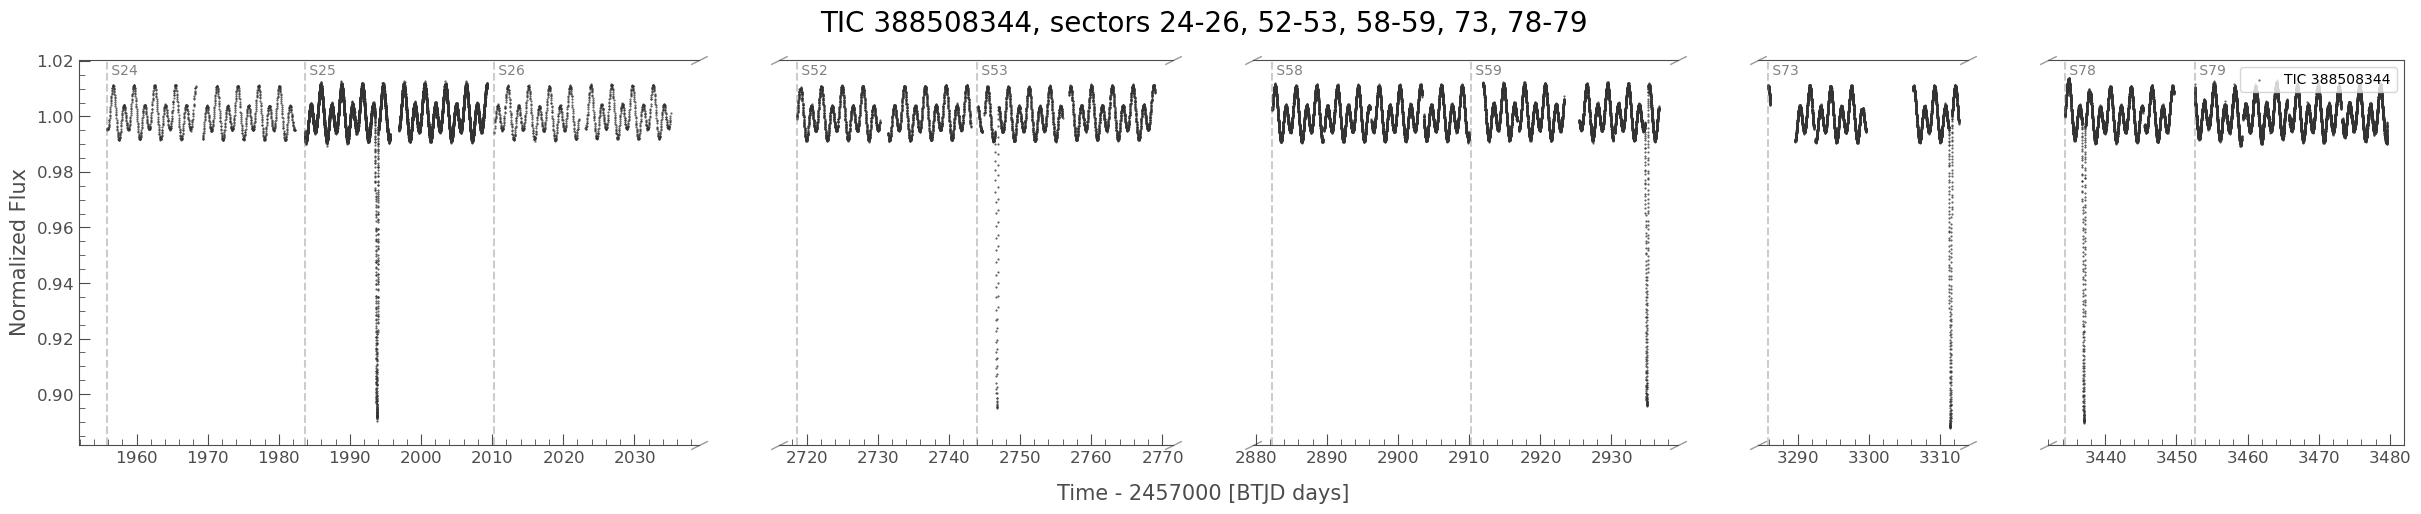

In [4]:
lc = lke.stitch(lcc_tess, ignore_incompatible_column_warning=True, )

axs = tplt.plot_skip_data_gap(lc, figsize=(30,5), s=1, alpha=0.9);
axs[0].get_figure().suptitle(f"{lc.label}, sectors {lke.abbrev_sector_list(lc)}", fontsize=20);
# [ax.set_ylim(0.85, 1.05) for ax in axs];

### Source Identifcation of the Variabilities

The observed variabilities in TESS data are all from the target.

In per-pixel plots, the variabilities all have similar spread centered around the target.

Eclipses:

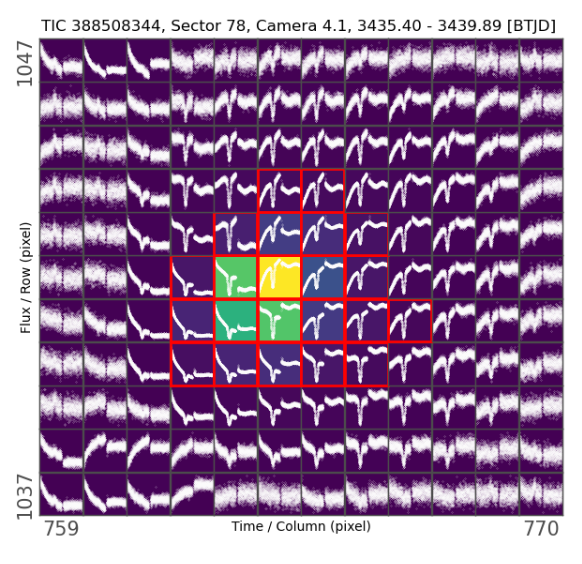
---

ELL:

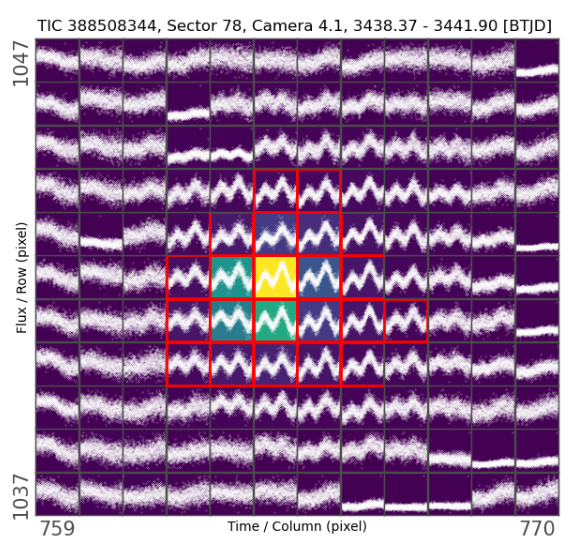


## MASCARA Variable data

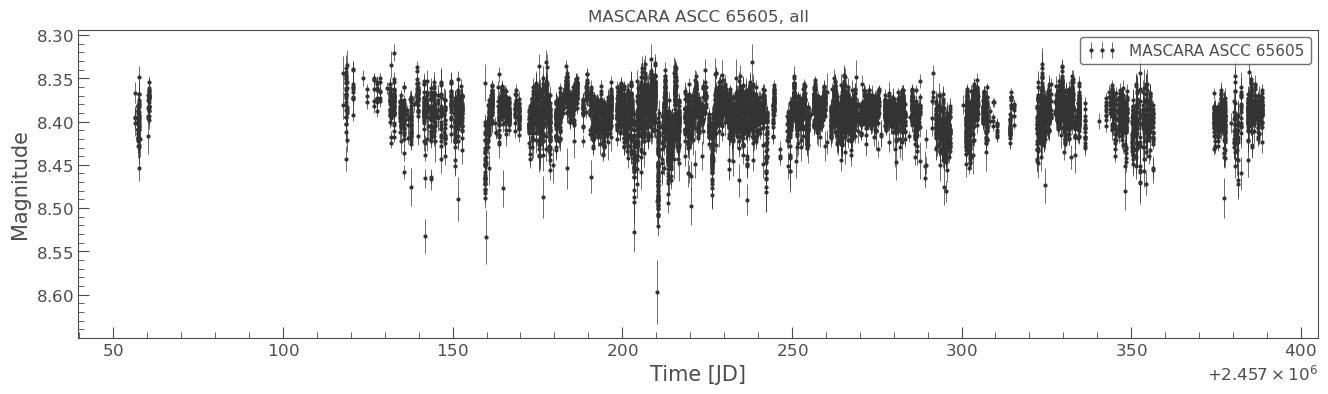

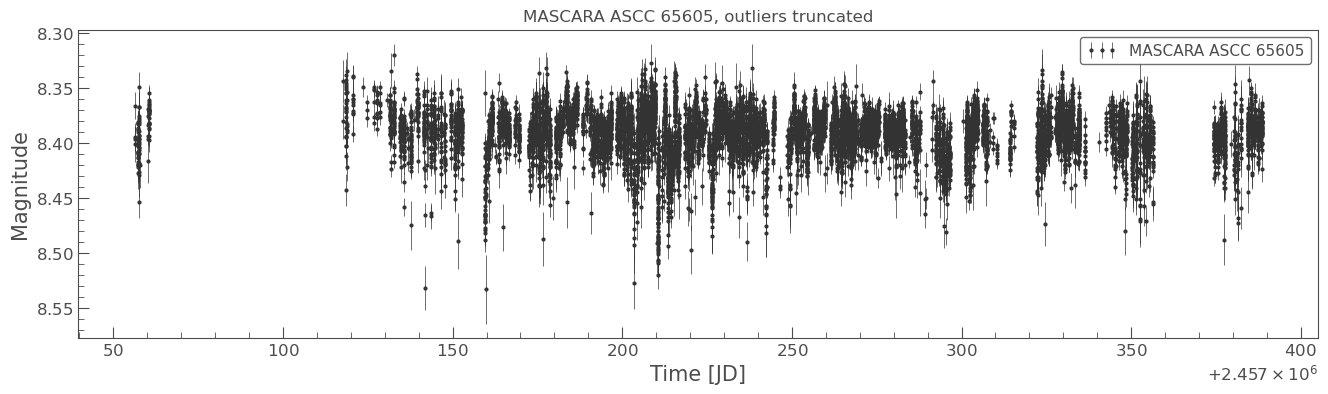

In [213]:
import lightkurve_ext_readers as lker
reload(lker)
# 
# from https://home.strw.leidenuniv.nl/~burggraaff/MASCARA_variables/on_disk/65605.html
_lc = lker.read_mascara_vars_fits("https://home.strw.leidenuniv.nl/~burggraaff/MASCARA_variables/on_disk/Data/65605_data.fit", reference_mag=8.329)
ax = tplt.errorbar(_lc, figsize=(16, 4));
ax.set_title(_lc.label + ", all");

# lots of data points much fainter than the expected range, especially before HJD 2453000
_lc = _lc.truncate(None, 8.56, column="flux") 
ax = tplt.errorbar(_lc, figsize=(16, 4));
ax.set_title(_lc.label + ", outliers truncated");

# _lc_f = _lc.fold(period=14.91, epoch_time=2453069.6, wrap_phase=None)  # initial epoch / period from existing VSX entry
# ax = tplt.scatter(_lc_f, s=25, c=_lc_f.time_original.value);

# ax = tplt.errorbar(_lc_f.truncate(-1, 1));
# ax.axvline(0, color="red", linestyle="--");
# ax.axvspan(-7/24/2, 7/24/2, color="red", alpha=0.3);

# use the outlier-truncated version
lc_mascara = _lc 

## Hipparcos data

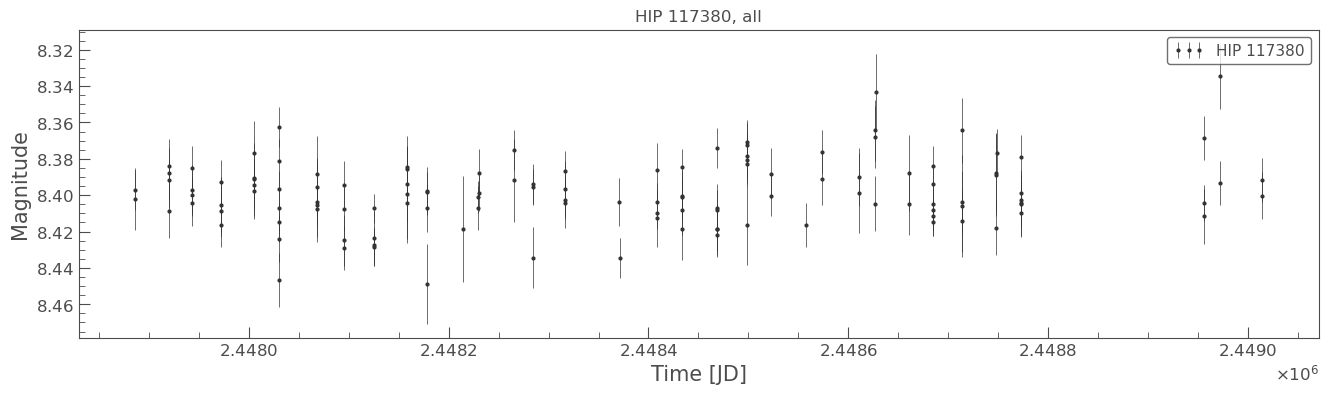

In [24]:
# See if ASAS-SN data is usable despite satuartion
# not too useful. one could barely see rotational varaiability in g

import lightkurve_ext_readers as lker

_lc = lker.read_hipparcos_data("https://cdsarc.cds.unistra.fr/viz-bin/nph-Plot/Vgraph/txt?I/239/117380")
ax = tplt.errorbar(_lc, figsize=(16, 4));
ax.set_title(_lc.label + ", all");

lc_hipparcos = _lc 

## Gaia DR3 info (coordinate, etc.)

In [10]:
# reload(lke)
# reload (lket)
rs_all_cols, rs, rs_html  = lket.search_gaiadr3_of_tics(tic, radius_arcsec=5, magnitude_range=None,  pm_error_factor=None, pm_range_fraction=None, pm_range_minimum=None, 
                                                        calc_separation_from_first_row=True,  # assuming the first row is the target, it'd calculate more accurately the separation for Gaia DR3 Main
                                                        compact_columns=True, also_return_html=True, also_return_astrophysical=False, verbose_html=True, include_nss_summary_in_html=False)
display(HTML(rs_html))

# from Gaia DR3
target_coord = SkyCoord(rs[0]["RAJ2000"], rs[0]["DEJ2000"], unit=(u.deg, u.deg), frame="icrs")
target_coord_dict = dict(ra=target_coord.ra.value, dec=target_coord.dec.value)


Listed as a DSCT|GDOR|SXPHE	with 1.46 d period in Gaia DR3 Variable. It seems to misclassify the ELL variability


In [11]:
# primary_name = f"TIC {tic}"
primary_name = "HIP 117380"   # use the name of the existing VSX entry
primary_name

'HIP 117380'

## Combining all data


TESS # data points: 85015
MASCARA # data points: 11105
Hipparcos # data points: 125


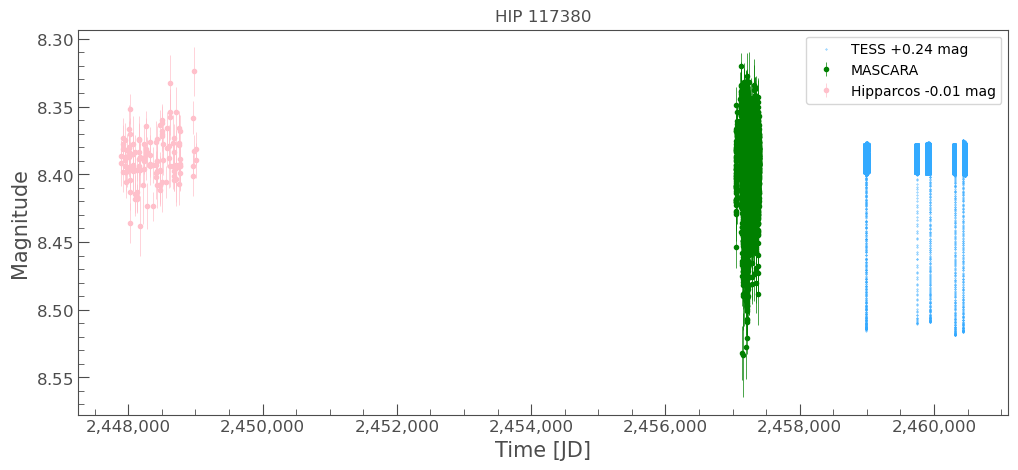

In [202]:
# Convert the data to magnitude and HJD/UTC

import lightkurve_ext_multi_sources as lkem
# reload(lkem)

lc_tess = lke.stitch(lcc_tess, ignore_incompatible_column_warning=True)
lc_tess = lke.to_flux_in_mag_by_normalization(lc_tess)
lc_tess = lke.convert_lc_time_to_hjd_utc(lc_tess, target_coord=target_coord, cache_dir=lk_download_dir)

# axs = tplt.plot_skip_data_gap(lc_tess, figsize=(30,5), s=4, alpha=0.9);

lc_combined_dict = lkem.combine_multi_bands_and_shift(
    {"TESS": lc_tess, 
     "MASCARA": lc_mascara,
     "Hipparcos": lc_hipparcos,
    }, 
    shift_to="MASCARA",
)

for k in lc_combined_dict.keys():
    print(f"{k} # data points:", len(lc_combined_dict[k]))

plot_options = lkem.get_default_plot_multi_bands_options_copy()
# for TESS plot (index 0) move it to the front
plot_options[0][1]["zorder"] = 9  # default 2

ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(12, 5), target_name=primary_name, plot_options=plot_options);
# ax.set_ylim(9.2, 8.75);


##  Eclipse epoch / period / duration

- use TESS data only, eclipses not found in the others

### Initial epoch / period / duration


Adopted period / epoch / duration_hr:  62.747 2460436.96 11.0


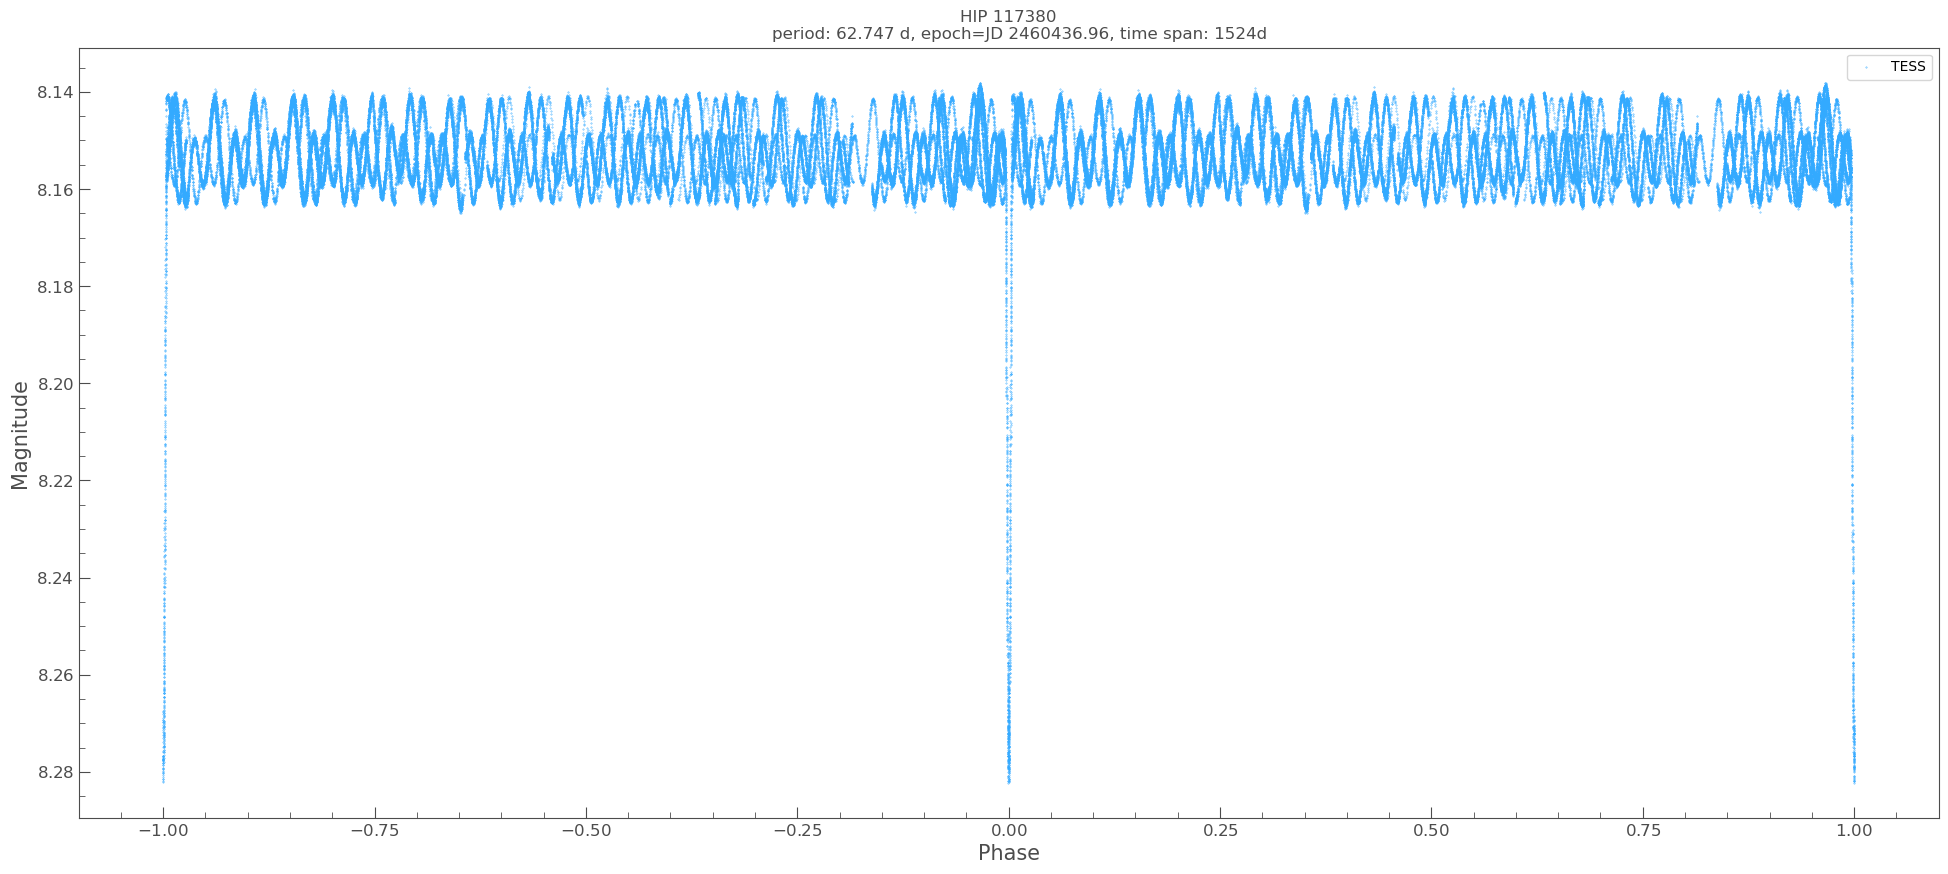

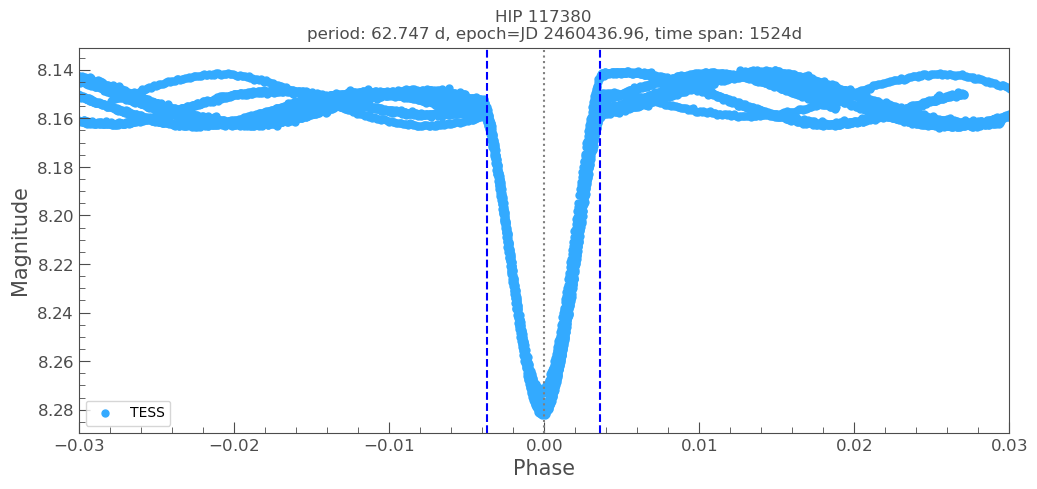

In [31]:
# from mnaul inspection of TESS data
period_trial = 62.747  # interact_bls
epoch_time_hjd_trial = round(lket.btjd_to_hjd_utc(3436.96, target_coord), 2)
duration_hr_min_i_trial = 11.0

print("Adopted period / epoch / duration_hr: ", period_trial, epoch_time_hjd_trial, duration_hr_min_i_trial)

# No Min II
# epoch_phase_min_ii_trial   = abs(epoch_time_min_ii_btjd_trial   - epoch_time_btjd_trial  ) / period_trial   % 1
# if epoch_phase_min_ii_trial   > 0.5:
#     epoch_phase_min_ii_trial   = epoch_phase_min_ii_trial   - 1
# epoch_phase_min_ii_trial  = round(epoch_phase_min_ii_trial  , 3)  # precsion from eyeballing zoomed plot

# print("Min II phase:", epoch_phase_min_ii_trial)

# --- Plot them to verify ---

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    {"TESS": lc_tess},
    period=period_trial,
    epoch=Time(epoch_time_hjd_trial   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    # plot_options=plot_options,
);


# zoom plot Min I
# - make TESS more visible:  larger dots
plot_options_zoom = lkem.get_default_plot_multi_bands_options_copy()
plot_options_zoom[0][1]["s"] = 25
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    {"TESS": lc_tess},
    period=period_trial  ,
    epoch=Time(epoch_time_hjd_trial   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_i_trial  ,  # for plotting only
    figsize=(12, 5),
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,  #
);
ylim = (None, None)
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.03, 0.03);  # to see primary in details



### Refine the period with MCMC on primary eclipses

- not too precise, as the eclipses also have ELL signals embedded, distorting its shape

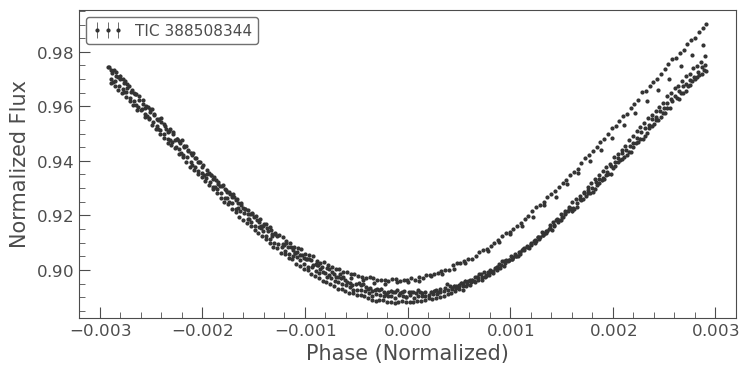

In [37]:
# reload(lke)

_lc = lke.to_normalized_flux_from_mag(lc_tess.remove_nans())

lc_f_min_i = _lc.fold(epoch_time=epoch_time_hjd_trial, period=period_trial, normalize_phase=True)
lc_f_min_i = lc_f_min_i.truncate((0 - duration_hr_min_i_trial / 24 * 0.4) / period_trial, (0 + duration_hr_min_i_trial /24 * 0.4) / period_trial)
# ax1 = tplt.scatter(lc_f_min_i, c=lc_f_min_i.time_original.value, s=25);
ax1 = tplt.errorbar(lc_f_min_i);



In [38]:
from types import SimpleNamespace

import sys
if "../eb_with_diff_sb_period/etv/" not in sys.path:  # for etvp
    sys.path.append("../eb_with_diff_sb_period/etv/")

import etv_functions_with_period as etvp
import etv_functions
# reload(etv_functions)

lc_f = lc_f_min_i

# # median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# # t0 in normalixed phase
start_vals = [1.0, -0.11, 0, 0.0019, 1.0]


# convert lc to the form needed by fit etv_functions
lc_f_data = SimpleNamespace(time=lc_f.time_original.value, phase=lc_f.time.value, flux=np.array(lc_f.flux.value), err=np.array(lc_f.flux_err.value))
etv_functions.plot_initial_guess_interactive(lc_f_data, None, None, None, "0", *start_vals)

Output(layout=Layout(padding='1em 0px'), outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Fig…

Output(layout=Layout(padding='1em'), outputs=({'name': 'stdout', 'text': '[1.0, -0.11, 0, 0.0016, 3.0]\n\n', '…

100%|██████████████████████████████████████████████████████████| 4000/4000 [02:01<00:00, 32.82it/s]


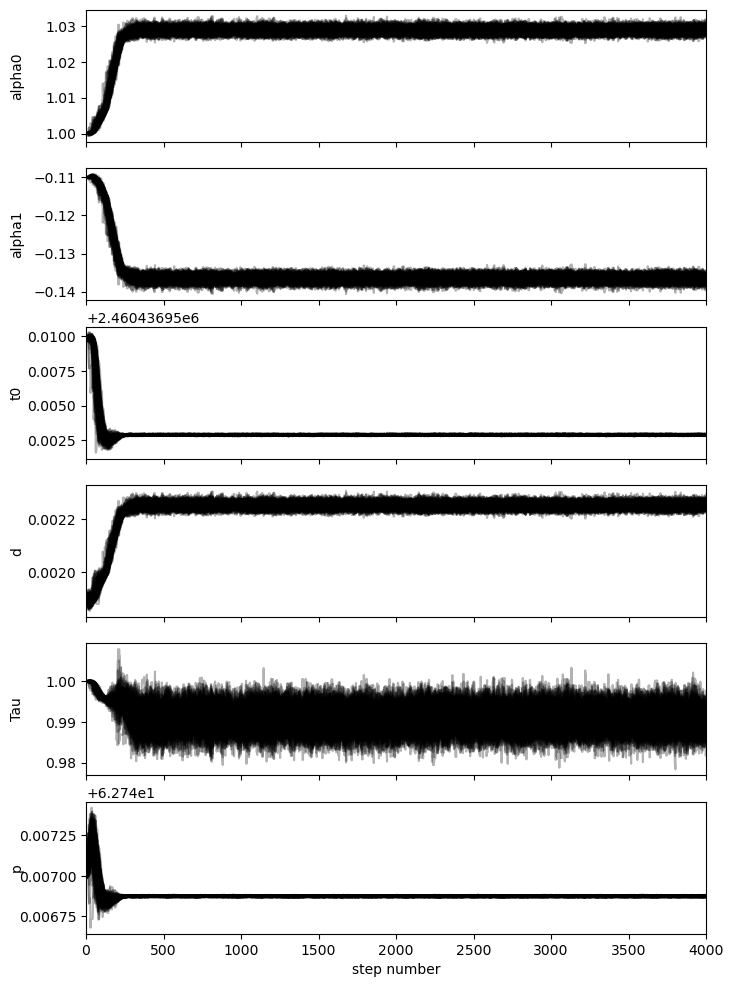

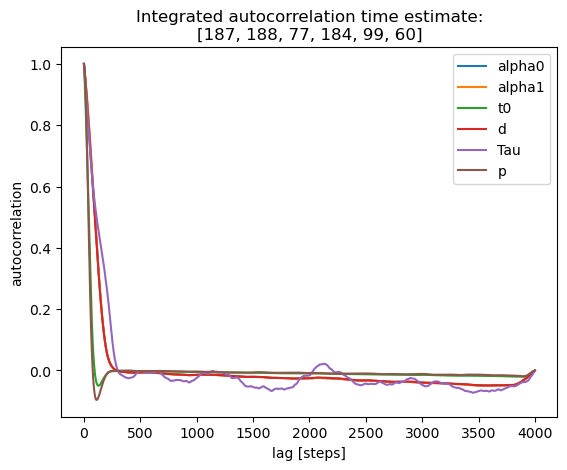

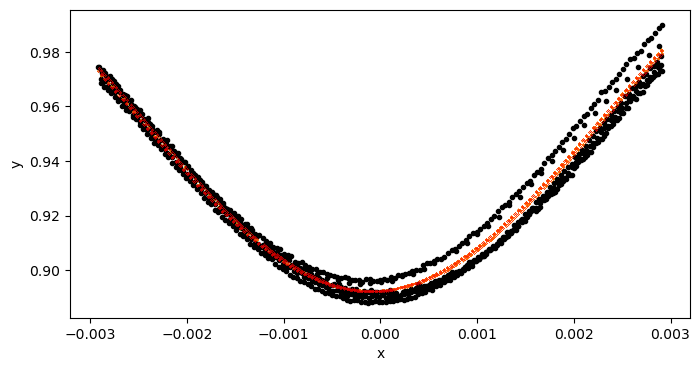

mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0287703030956161, -0.13650819976604722, 2460436.9528855835, 0.002253065716186476, 0.9908016047751246, 62.74687258207162
std_p: 2.790716989916461e-06


In [40]:
mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats  = etvp.run_mcmc_initial_fit_p(
    lc_f_data, 
    [1.0, -0.11, epoch_time_hjd_trial, 0.0019, 1.0, period_trial],
    # nruns=20, discard=1,
    nruns=4000, discard=1000,
    autocorr_time_kwargs=dict(tol=20),  # the emcee defaults tol=50 seems to be too strict for our use case, tol of ~10 - 20 seems to be sufficient    
    pool=-2, 
    plot_chains=True, plot_autocorrelation=True, plot=True, 
    also_return_stats=True,
)

print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
print("std_t0:", fit_params_p_stats["std_t0"])
print("std_p:", fit_params_p_stats["std_p"])


In [41]:
print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
print("std_t0:", fit_params_p_stats["std_t0"])
print("std_p:", fit_params_p_stats["std_p"])


mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0287703030956161, -0.13650819976604722, 2460436.9528855835, 0.002253065716186476, 0.9908016047751246, 62.74687258207162
std_t0: 3.1680294621173115e-05
std_p: 2.790716989916461e-06


### Final epoch / period / duration


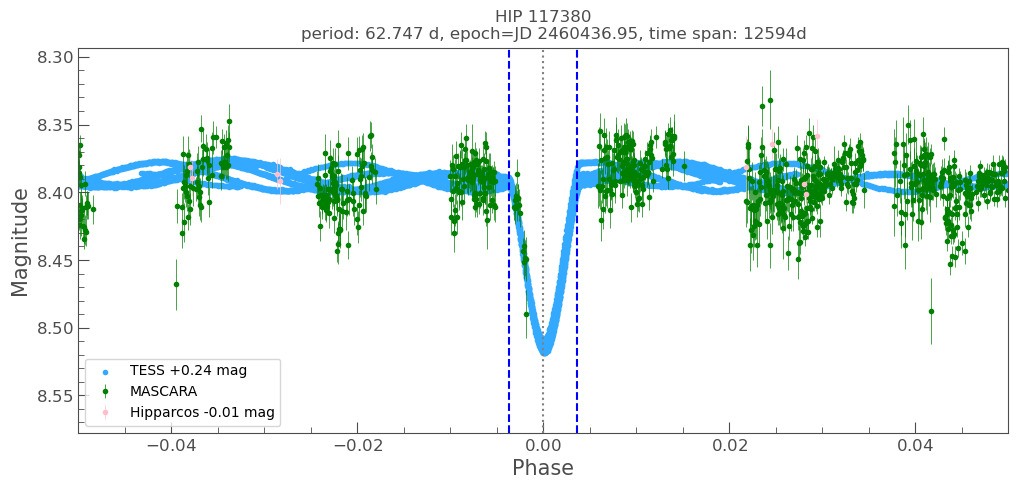

In [205]:
# Cannot tell the difference between TCE period and BLS period, cut 1 digit and choose the best
period_final = 62.747   # from MCMC, precision adjusted from inspecting folded LC below
epoch_time_hjd_final = 2460436.95  # from MCMC

duration_hr_min_i_final = duration_hr_min_i_trial


# --- Plot them to verify ---

# ax, lc_f_res = lkem.fold_n_plot_multi_bands(
#     {"TESS": lc_tess},
#     period=period_final,
#     epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
#     phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
#     figsize=(24, 10),
#     target_name=primary_name,
#     # plot_options=plot_options,
# );
# ylim = (None, None)
# ax.set_ylim(*ylim);


# zoom plot Min I
# - make TESS more visible:  larger dots
plot_options_zoom = lkem.get_default_plot_multi_bands_options_copy()
plot_options_zoom[0][1]["s"] = 9
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,  # {"TESS": lc_tess},
    period=period_final  ,
    epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_i_final  ,  # for plotting only
    figsize=(12, 5),
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,  #
);
# ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.05, 0.05);  # to see primary in details


## Rotation (ELL) epoch / period

### Rotation period trial / refinement

#### Trial with Lomb-Scargle, MCMC and visual inspection of candidate periods

- ANOVA skipped

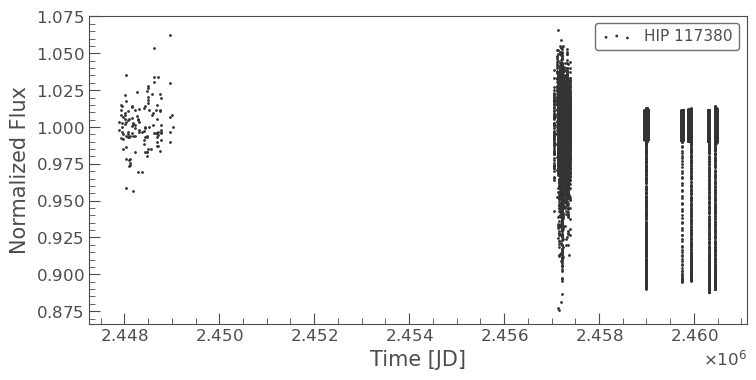

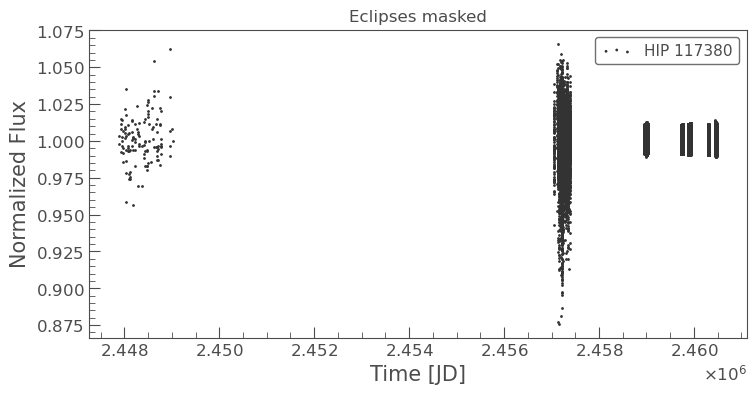

In [206]:
lc = lke.stitch_lc_dict(lc_combined_dict).remove_nans().remove_nans(column="flux_err")
ax = tplt.scatter(lc);

lc_combined_dict_no_ecl = dict()
for key, _lc in lc_combined_dict.items():
    tmask = _lc.create_transit_mask(period=period_final, transit_time=epoch_time_hjd_final, duration=duration_hr_min_i_final/24 * 1.4)
    _lc = _lc[~tmask]
    lc_combined_dict_no_ecl[key] = _lc

    
lc = lke.stitch_lc_dict(lc_combined_dict_no_ecl).remove_nans().remove_nans(column="flux_err")
ax = tplt.scatter(lc);
ax.set_title("Eclipses masked");

In [55]:
pg = (
    lc
    # lke.to_normalized_flux_from_mag(lc_tess)
    .to_periodogram(method="lombscargle",
                    # use the frequency grid from TESS data only (otherwise we hit some IndexError from lightkurve / astropy)
                    frequency=u.Quantity(np.linspace(0.00011716, 216.00221815 , num=1843586), unit=1/u.d),
                    # minimum_period=0.5, maximum_period=100,
                    # oversample_factor=50,  # default: 5
                    ls_method="fastchi2", nterms=2,
                      )
     )
print(len(lc), lc.time.max() - lc.time.min(), lc.time.min(), lc.time.max(), )
pg.show_properties();

print("period_at_max_power:", pg.period_at_max_power, "/", pg.frequency_at_max_power.to(u.microhertz))


89795 12593.91510374036 2447885.7554297224 2460479.670383
lightkurve.Periodogram properties:
      Attribute          Description    Units
---------------------- ---------------- -----
                nterms                2      
              targetid           117380      
          default_view        frequency      
                 label       HIP 117380      
             ls_method         fastchi2      
frequency_at_max_power           0.3424 1 / d
             max_power           0.0076      
               nyquist         215.9827 1 / d
   period_at_max_power            2.921     d
             frequency array (1843586,) 1 / d
                period array (1843586,)     d
                 power array (1843586,)      
                  meta   <class 'dict'>      
period_at_max_power: 2.920955792616207 d / 3.962426991648355 uHz


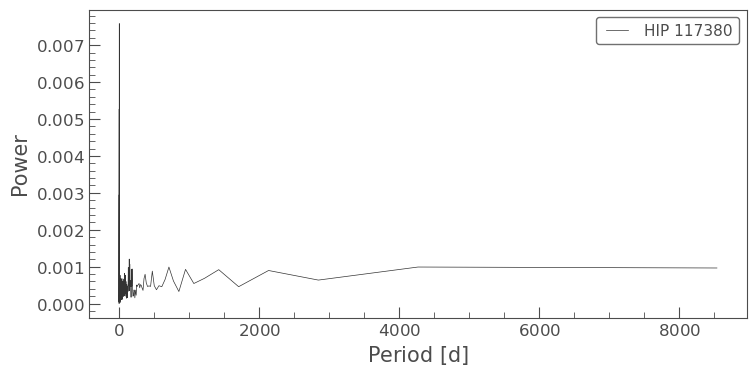

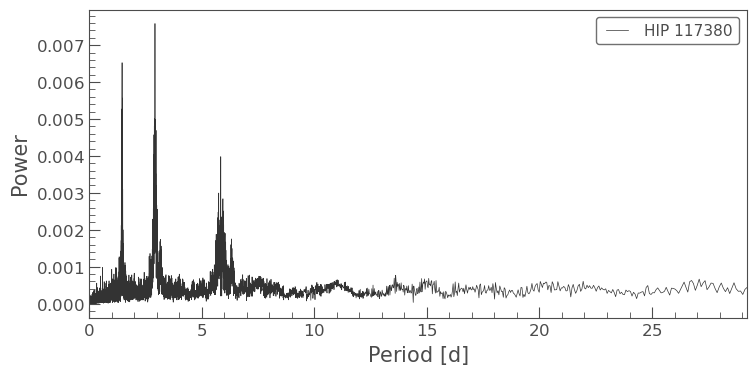

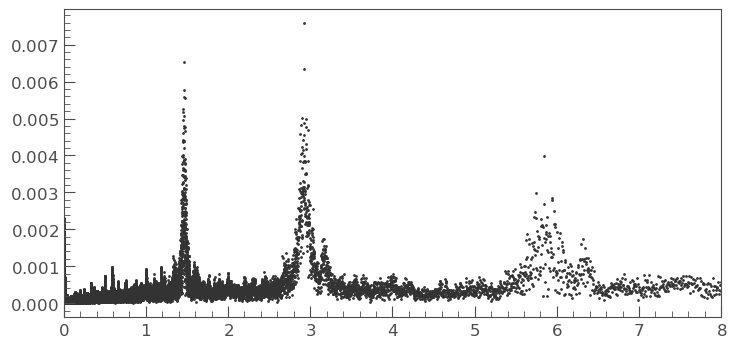

In [58]:
ax = pg.plot(view="period"); 

ax = pg.plot(view="period"); 
ax.set_xlim(0, pg.period_at_max_power.value * 10);

ax = tplt.lk_ax()
ax.scatter(pg.period.value, pg.power.value, s=1);
ax.set_xlim(0, 8);

In [59]:
# reload(lke_pg)
peaks = lke_pg.find_peaks(
    pg, 
    # pg[pg.frequency < 500 * u.microhertz], 
    powerlimit=10**-4,   
)
if "period" not in peaks.columns:
    peaks["period"] = 1 / peaks["frequency"]
    peaks["period"].unit = 1 / peaks["frequency"].unit
if "frequency" not in peaks.columns:
    peaks["frequency"] = 1 / peaks["period"]
    peaks["frequency"].unit = 1 / peaks["period"].unit
peaks["frequency_u"] = u.Quantity(peaks["frequency"]).to(u.microhertz)  # in microhertz, for log scale plot
peaks["period_h"] = u.Quantity(peaks["period"]).to(u.hour)  # period in hours
peaks["rank"] = np.linspace(1, len(peaks), len(peaks), dtype=int)

peaks[peaks["period"] > 0][:15]
# peaks[peaks["frequency"] > 100][:15]  # in 1/d
# peaks[peaks["frequency_u"] > 200][:15]
# peaks[peaks["frequency_ratio"] < 5][:15]
# peaks[(1.4 < peaks["period"]) & (peaks["period"] < 1.6)][:15]
# peaks[(100 < peaks["frequency_u"]) & (peaks["frequency_u"] < 500)][:15]
# peaks[:15]

<Table length=15>
        power              frequency            prominence      ...      period_h       rank
                             1 / d                              ...         h               
       float64              float64              float64        ...      float64       int32
--------------------- ------------------- --------------------- ... ------------------ -----
 0.007583858274162145 0.34235369207841787  0.007551734805785901 ...  70.10293902278897     1
 0.006523712283501863  0.6847073883239286  0.006491281559567206 ...   35.0514692980731     2
 0.005564125292684452  0.6792006724705614  0.005112833224677345 ... 35.335654060384094     3
0.0052689942076677475    0.68997977584311  0.004438566837141438 ...   34.7836282167453     4
 0.005076488381709215  0.6831842541517207  0.004288987345881995 ... 35.129615259941446     5
  0.00517121307669045  0.6859961941619507  0.004134724658671931 ... 34.985616836139556     6
0.0039790540861423624  0.1711768439556625  0.003939604605092843 ... 140.20587975214906     7
 0.005003520846066584   0.345048467921555  0.003641231871195534 ...   69.5554457742333     8
 0.004572192530675652  0.3477432437646922 0.0034927442719690253 ...  69.01643793327041     9
 0.004362502444346117  0.6915029100153179 0.0033337088599006658 ...  34.70701229510134    10
  0.00469068052481406 0.33684697622505066  0.003278300308929172 ...  71.24896969229545    11
 0.003464531674627473  0.6954864916964772 0.0031949525144750286 ... 34.508218759874964    12
 0.003390546272520447  0.6736939566171942 0.0031684513523594408 ...  35.62448462579464    13
0.0048118063723038736  0.3457514529241125  0.003037157356543785 ...  69.41402500850128    14
 0.003908845395722887  0.6777947024654464  0.003036370954166787 ...  35.40895187392455    15

In [76]:
1.4604778874197124  * 2

2.920955774839425

In [78]:
pg_single = (
    lc
    # lke.to_normalized_flux_from_mag(lc_tess)
    .to_periodogram(method="lombscargle",
                    # use the frequency grid from TESS data only (otherwise we hit some IndexError from lightkurve / astropy)
                    frequency=u.Quantity(np.linspace(0.00011716, 216.00221815 , num=1843586), unit=1/u.d),
                    # minimum_period=0.5, maximum_period=100,
                    # oversample_factor=50,  # default: 5
                      )
     )
print(len(lc), lc.time.max() - lc.time.min(), lc.time.min(), lc.time.max(), )
pg_single.show_properties();

print("period_at_max_power:", pg_single.period_at_max_power, "/", pg_single.frequency_at_max_power.to(u.microhertz))
print("2X period_at_max_power:", pg_single.period_at_max_power * 2)

89795 12593.91510374036 2447885.7554297224 2460479.670383
lightkurve.Periodogram properties:
      Attribute          Description    Units
---------------------- ---------------- -----
                nterms                1      
              targetid           117380      
          default_view        frequency      
                 label       HIP 117380      
             ls_method             fast      
frequency_at_max_power           0.6847 1 / d
             max_power           0.0065      
               nyquist         215.9827 1 / d
   period_at_max_power           1.4605     d
             frequency array (1843586,) 1 / d
                period array (1843586,)     d
                 power array (1843586,)      
                  meta   <class 'dict'>      
period_at_max_power: 1.4604778874197124 d / 7.9248540315269524 uHz
2X period_at_max_power: 2.920955774839425 d


In [ ]:
ax = tplt.lk_ax(figsize=(12, 4))
ax.scatter(pg.period.value, pg.power.value, s=1);
ax.set_xlim(12, 19);
ax.axvline(pg.period_at_max_power.value, color="blue", linestyle="--");
ax.axvline(14.91, color="red", linestyle="--");  # VSX value
ax.axvline(14.799471, color="green", linestyle="--");  # a sub-peak 
ax.axvline(15.455404, color="green", linestyle="--");  # a sub-peak 
ax.axvline(15.783312, color="green", linestyle="--");  # a sub-peak 



Final adopted rot_period_trial: 2.921


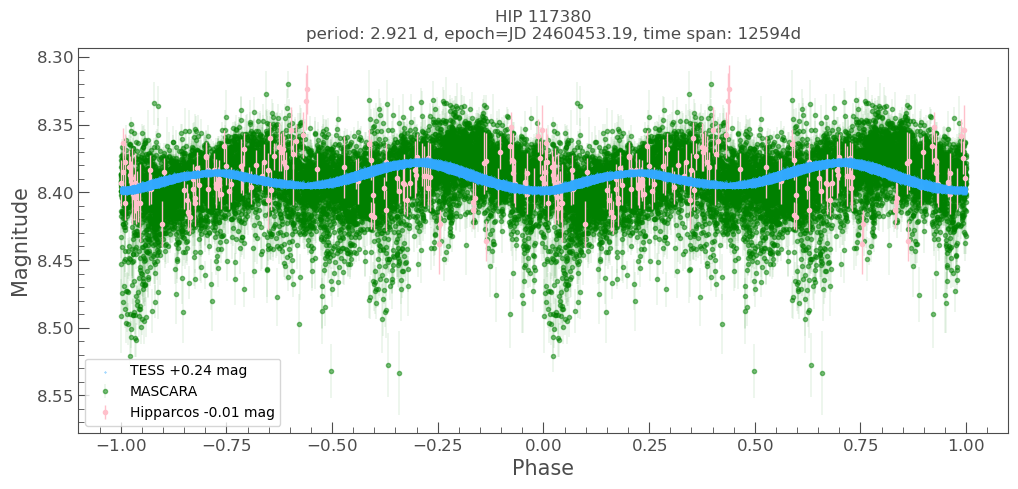

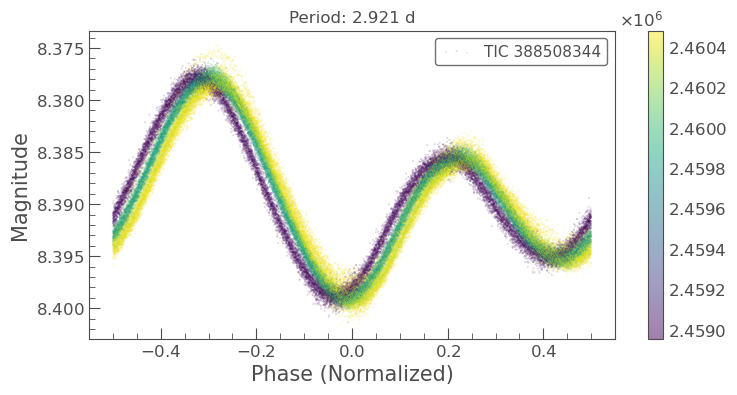

In [105]:
plot_options = lkem.get_default_plot_multi_bands_options_copy()
plot_options[0][1]["zorder"] = 9  # push TESS data to the top
plot_options[1][1]['linewidth'] = 0.2
plot_options[1][1]['alpha'] = 0.5
plot_options[2][1]['linewidth'] = 1
plot_options[2][1]['zorder'] = 8

for rot_period_trial in [ 
    # 2.922255,  # green+ 2023 value
    # 2.923,  # VSX value X 2
    # 2.9209558,  # 2.920955792616207,  # LombScargle (nterms=2) peak
    # 2.92096,  # rounded LS
    2.9210, # rounded LS, this seems to be sufficient
    # 2.920955774839425,  # LombScargle (nterms=1) peak X 2, basically the same as LombScargle (nterms=2)
    # 2.8981435739263874, # LS sub-peak, clearly sub-optimal
    # 2.8756849138862672, # LS sub-peak, clearly sub-optimal
    # 2.9687070705123104, # LS sub-peak, clearly sub-optimal
    
]: 
    rot_epoch_time_hjd_trial = 2460453.19  #  round(lket.btjd_to_hjd_utc(3453.19, target_coord), 2)  # inspection in TESS lC
    
    ax, lc_f_res = lkem.fold_n_plot_multi_bands(
        lc_combined_dict_no_ecl,
        period=rot_period_trial,
        epoch=Time(rot_epoch_time_hjd_trial, format="jd", scale="utc"),
        phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
        figsize=(12, 5),
        target_name=primary_name,
        plot_options=plot_options,
    );

    _lc = lc_f_res["TESS"]
    ax = tplt.scatter(_lc, s=0.1, alpha=0.5, c=_lc.time_original.value);
    ax.set_title(f"Period: {_lc.period}");

print("Final adopted rot_period_trial:", rot_period_trial)

#### Refine the ELL period with MCMC

- not quite precise: the `cosh` Gaussian model is symmetric in shape, while the ELL here is slighly asymnetric

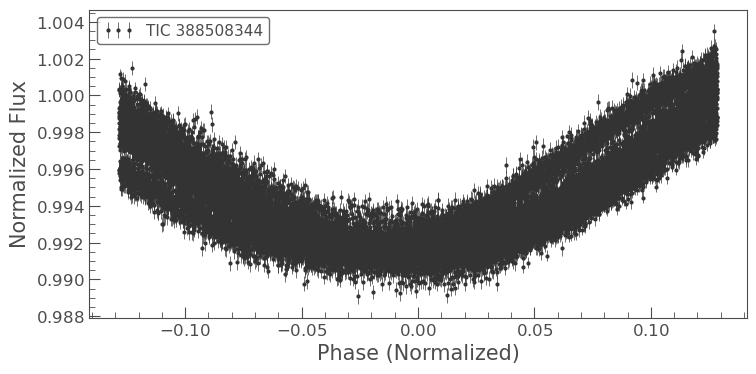

In [98]:
_lc = lke.to_normalized_flux_from_mag(lc_combined_dict_no_ecl["TESS"].remove_nans())

_lc_f_ell_min_i = _lc.fold(epoch_time=rot_epoch_time_hjd_trial, period=rot_period_trial, normalize_phase=True)
_lc_f_ell_min_i = _lc_f_ell_min_i.truncate((0 - 9/24) / rot_period_trial, (0 + 9/24) / rot_period_trial)
# ax1 = tplt.scatter(_lc_f_ell_min_i, c=_lc_f_ell_min_i.time_original.value, s=25);
ax1 = tplt.errorbar(_lc_f_ell_min_i);


In [99]:
from types import SimpleNamespace

import sys
if "../eb_with_diff_sb_period/etv/" not in sys.path:  # for etvp
    sys.path.append("../eb_with_diff_sb_period/etv/")

import etv_functions_with_period as etvp
import etv_functions
# reload(etv_functions)

lc_f = _lc_f_ell_min_i

# # median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# # t0 in normalized phase
start_vals = [1.0, -0.0085, 0, 0.09, 0.95]

# convert lc to the form needed by fit etv_functions
lc_f_data = SimpleNamespace(time=lc_f.time_original.value, phase=lc_f.time.value, flux=np.array(lc_f.flux.value), err=np.array(lc_f.flux_err.value))
etv_functions.plot_initial_guess_interactive(lc_f_data, None, None, None, "0", *start_vals)

Output(layout=Layout(padding='1em 0px'), outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Fig…

Output(layout=Layout(padding='1em'), outputs=({'name': 'stdout', 'text': '[1.0, -0.01, 0, 0.0019, 1.0]\n\n', '…

100%|██████████████████████████████████████████████████████████| 4000/4000 [32:30<00:00,  2.05it/s]
The chain is shorter than 20 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/20 = 200;
tau: [ 86.85640564  80.59403293 122.04103499  50.35977274 231.7113317
  29.54061999]


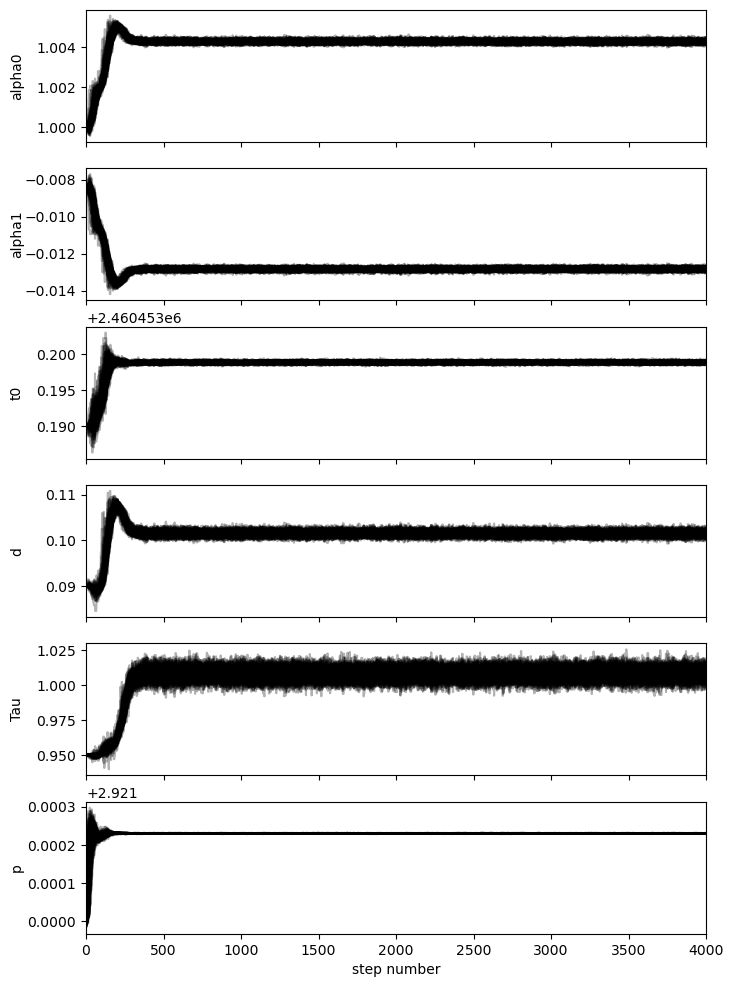

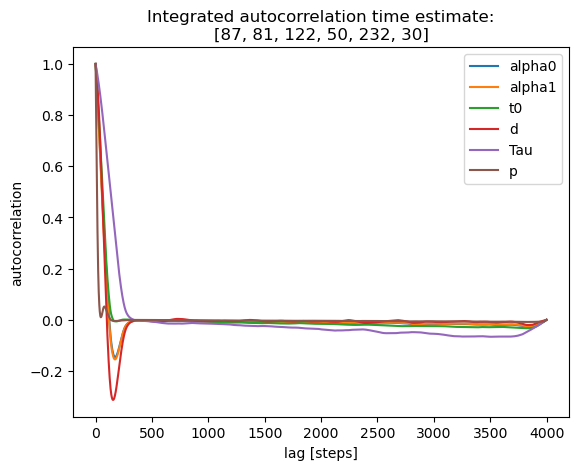

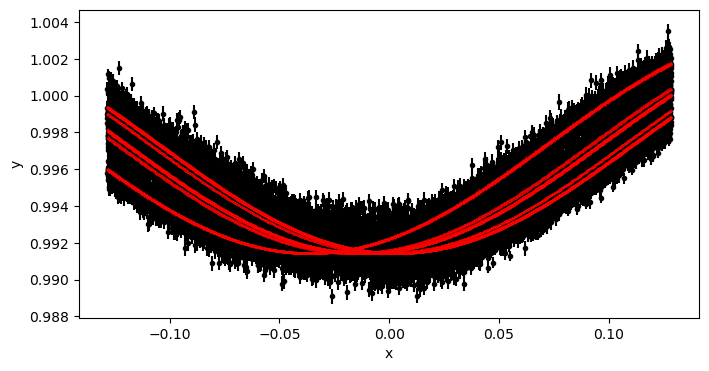

mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0042639405808949, -0.012829467344670647, 2460453.1988439765, 0.10146645801827434, 1.0078575193273371, 2.9212296464972995
std_t0: 0.00014298820358106968
std_p: 5.061077088415167e-07


In [101]:
mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats  = etvp.run_mcmc_initial_fit_p(
    lc_f_data, 
    [1.0, -0.0085, rot_epoch_time_hjd_trial, 0.09, 0.95, rot_period_trial],
    # nruns=20, discard=1,
    nruns=4000, discard=1000,
    autocorr_time_kwargs=dict(tol=20),  # the emcee defaults tol=50 seems to be too strict for our use case, tol of ~10 - 20 seems to be sufficient    
    pool=-2, 
    plot_chains=True, plot_autocorrelation=True, plot=True, 
    also_return_stats=True,
)

print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
print("std_t0:", fit_params_p_stats["std_t0"])
print("std_p:", fit_params_p_stats["std_p"])


In [175]:
# Note: the better period from MCMC, 2.9212, is missing in the LS frequency grid
_p = 1 / pg.frequency.value  # in days
_p[(2.920 < _p) & (_p < 2.922)]

array([2.92195578, 2.92095579])

In [ ]:
# for rot_period_trial in np.linspace(14.85, 14.95, num=11): 
#     rot_epoch_time_hjd_trial = 2453069.6  # VSX
    
#     ax, lc_f_res = lkem.fold_n_plot_multi_bands(
#         lc_combined_dict,
#         period=rot_period_trial,
#         epoch=Time(rot_epoch_time_hjd_trial   , format="jd", scale="utc"),
#         phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
#         figsize=(12, 5),
#         target_name=primary_name,
#         plot_options=plot_options,
#     );
#     ax.set_ylim(9.2, 8.75);


In [ ]:
# the best period seems to be around 14.913 - 14.914
# export combined data for period analysis outside the notebook

# lc = lke.stitch_lc_dict(lc_combined_dict, normalize=False)
# lc = lc.truncate(None, 9.2, column="flux")
# ax = tplt.scatter(lc);
# lc.to_pandas().to_csv(f"{lk_download_dir}/tmp_in/tic385464250_tess_asas3.csv")


In [ ]:
# for rot_period_trial in [  # peaks from # VStar ANOVA
#     14.91382,
#     14.91383,
#     14.91384,
#     14.91385,
#     14.91371,
#     14.91374,
#     14.91376,
#     14.91373,
# ]: 

#     rot_epoch_time_hjd_trial = 2456321.94  # VStar ANOVA
    
    
#     ax, lc_f_res = lkem.fold_n_plot_multi_bands(
#         lc_combined_dict,
#         period=rot_period_trial,
#         epoch=Time(rot_epoch_time_hjd_trial   , format="jd", scale="utc"),
#         phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
#         figsize=(12, 5),
#         target_name=primary_name,
#         plot_options=plot_options,
#     );
#     ax.set_ylim(9.2, 8.75);



#### Trial to determine the period using Multiband Lomb-Scargle (skipped)

https://docs.astropy.org/en/stable/timeseries/lombscarglemb.html

In [ ]:
from astropy.timeseries import LombScargleMultiband

lc = lke.stitch_lc_di#ct(lc_combined_dict).remove_nans().remove_nans(column="flux_err")
lc = lc.truncate(0.8, None, column="flux")
tplt.scatter(lc)

lsm = LombScargleMultiband(lc.time, lc.flux, lc.source, lc.flux_err)
lsm

In [ ]:
%%time

# lsm.autopower(method="flexible") , aka, the default, takes forever to run, see if I can get some approx results sooner

frequency = lsm.autofrequency()
period = 1 / frequency
power = lsm.power(frequency, method="fast")
len(power), np.max(power), period[np.argmax(power)], frequency[np.argmax(power)]

In [ ]:
%%time

# lsm.autopower(method="flexible") , aka, the default, takes forever to run, see if I can get some approx results sooner

# use the frequency grid from TESS data only in plain LS
frequency = u.Quantity(np.linspace(8.96e-5, 215.99, num=2410189), unit=1/u.d)
period = 1 / frequency
power = lsm.power(frequency, method="fast")
print(len(power), np.max(power), period[np.argmax(power)], frequency[np.argmax(power)])
print(np.mean(np.diff(frequency)))

In [ ]:
%%time

# lsm.autopower(method="flexible") , aka, the default, takes forever to run, see if I can get some approx results sooner

# use a much narrower frequency range , but the grid spacing is about the same as the one used in plain LS
frequency = u.Quantity(np.arange(1/30, 1/2, step=8.962e-5), unit=1/u.d)  
print("num. freq:", len(frequency))
period = 1 / frequency
power = lsm.power(frequency, method="flexible")  # the default, takes longer than method="fast"
len(power), np.max(power), period[np.argmax(power)], frequency[np.argmax(power)]

In [ ]:
ax = tplt.lk_ax();
ax.plot(period, power); ax.set_xlabel("period [d]"), ax.set_ylabel("Power");

ax = tplt.lk_ax();
ax.plot(period, power); ax.set_xlabel("period [d]"), ax.set_ylabel("Power");
ax.set_xlim(12, 19);
ax.set_title(f"Peak period: {period[np.argmax(power)]}")
ax.axvline(period[np.argmax(power)].value, color="blue", linestyle="--");

ax = tplt.lk_ax();
ax.plot(period, power); ax.set_xlabel("period [d]"), ax.set_ylabel("Power");
ax.scatter(period, power);
ax.set_xlim(14, 16);
ax.set_title(f"Peak period: {period[np.argmax(power)]}")
ax.axvline(period[np.argmax(power)].value, color="blue", linestyle="--");

# The period tried
period[(14.75 < period.value) & (period.value < 15.25)]

In [ ]:
%%time

# use a much narrower frequency range , but the grid spacing is finer (smaller step size)
frequency = u.Quantity(np.arange(1/25, 1/5, step=8.962e-5 / 5), unit=1/u.d)  
print("num. freq:", len(frequency))
period = 1 / frequency
power = lsm.power(frequency, method="flexible")  # the default, takes longer than method="fast"
len(power), np.max(power), period[np.argmax(power)], frequency[np.argmax(power)]

In [ ]:
ax = tplt.lk_ax();
ax.plot(period, power); ax.set_xlabel("period [d]"), ax.set_ylabel("Power");

ax = tplt.lk_ax();
ax.plot(period, power); ax.set_xlabel("period [d]"), ax.set_ylabel("Power");
ax.set_xlim(12, 19);
ax.set_title(f"Peak period: {period[np.argmax(power)]}")
ax.axvline(period[np.argmax(power)].value, color="blue", linestyle="--");

ax = tplt.lk_ax();
ax.plot(period, power); ax.set_xlabel("period [d]"), ax.set_ylabel("Power");
ax.scatter(period, power);
ax.set_xlim(14, 16);
ax.set_title(f"Peak period: {period[np.argmax(power)]}")
ax.axvline(period[np.argmax(power)].value, color="blue", linestyle="--");

# The period tried
period[(14.85 < period.value) & (period.value < 15.15)]

### Final rotation epoch / period

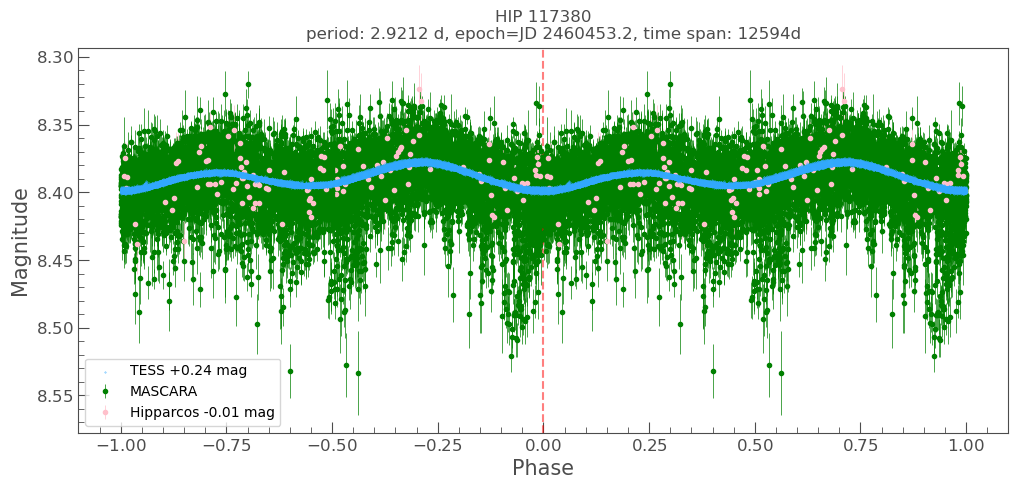

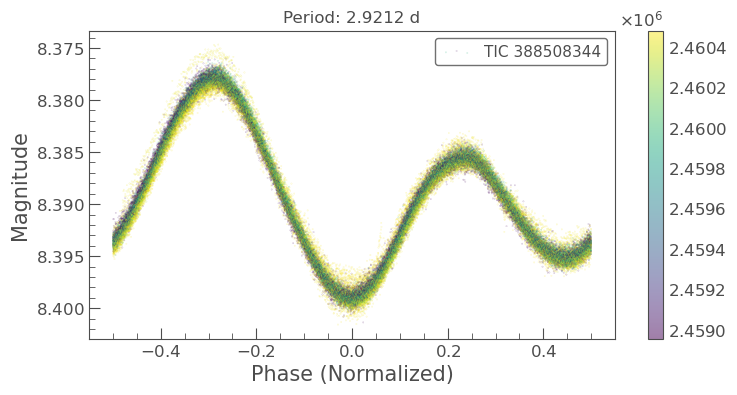

In [207]:
rot_period_final = 2.9212    # MCMC: 2.9212296464972995 
rot_epoch_time_hjd_final = 2460453.20  # MCMC: 2460453.1988439765, 


ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict_no_ecl,
    period=rot_period_final, # shorter period, around 2.9207, would make MASCARA and TESS data fit better, but at the expanse of Hipparocos, and TESS-only data
    epoch=Time(rot_epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(12, 5),
    target_name=primary_name,
    plot_options=plot_options,
);
ax.axvline(0, color="red", alpha=0.5, linestyle="--");
# ax.set_ylim(9.2, 8.75);

_lc = lc_f_res["TESS"]
ax = tplt.scatter(_lc, s=0.1, alpha=0.5, c=_lc.time_original.value);
ax.set_title(f"Period: {_lc.period}");

## Determine Overall amplitude and Eclipse amplitude (TESS)

Absolute max: 8.374677 , 99.5 percentile: 8.377226829528809
Min I mag # num data points: 15
['8.3920', '8.5142']
(0.12, 0.14)


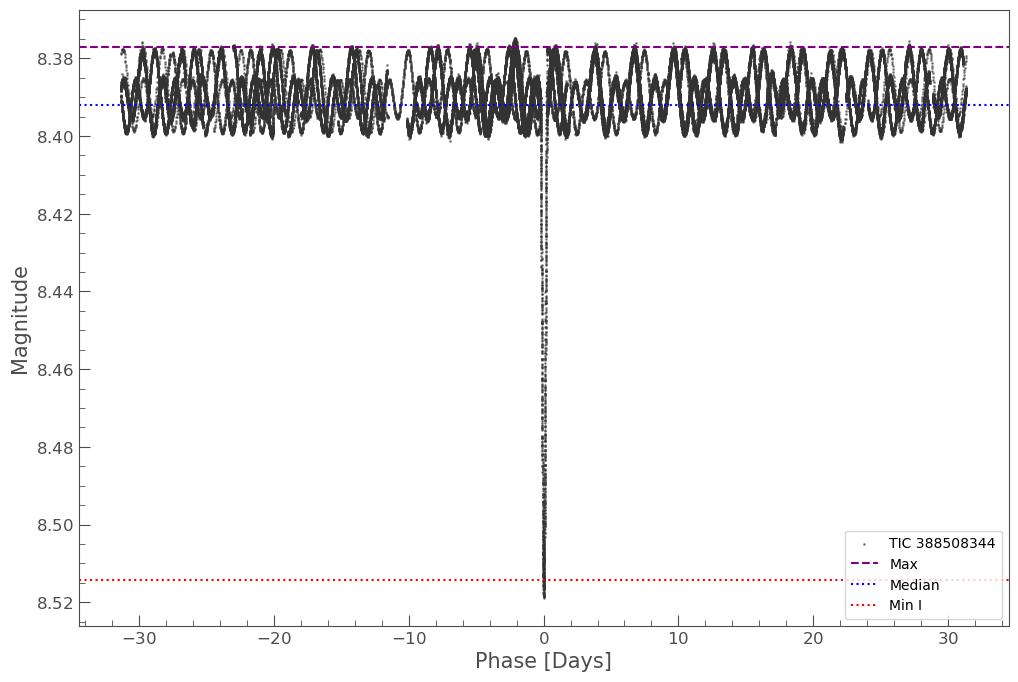

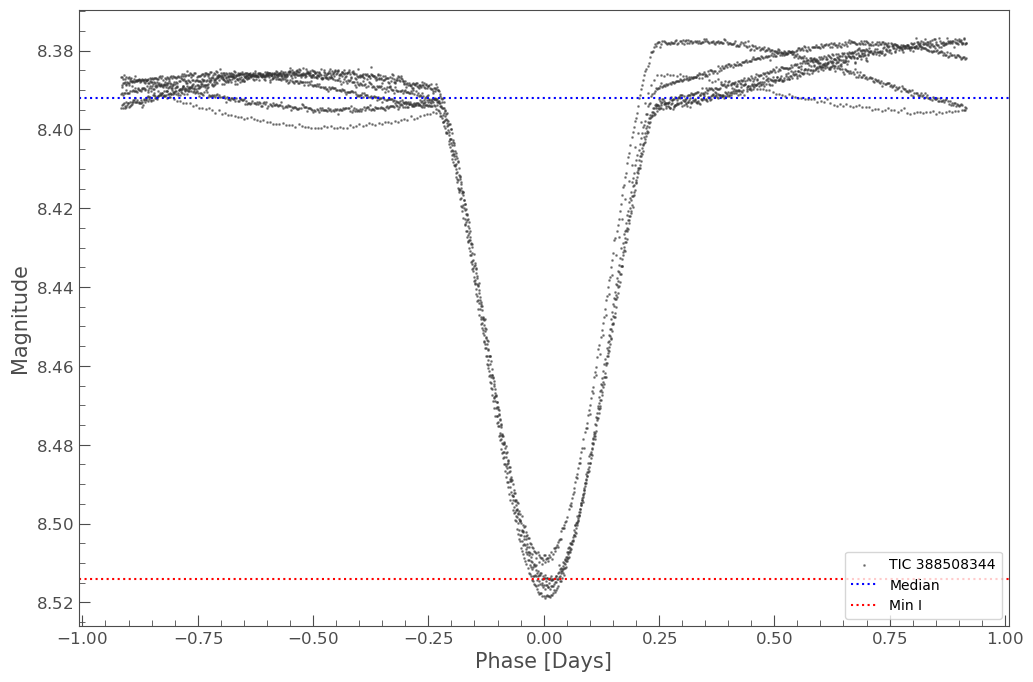

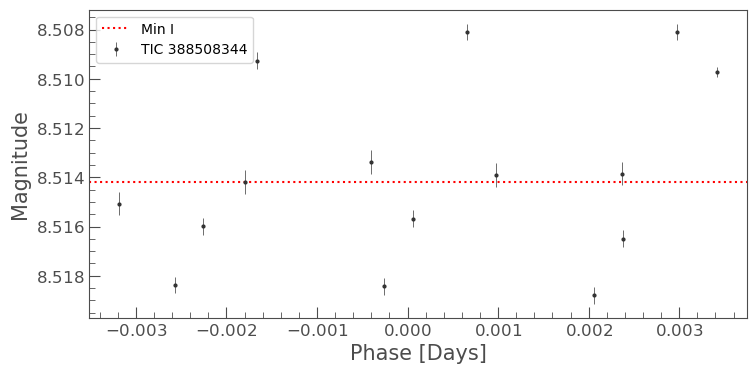

In [233]:
%matplotlib inline

lc = lc_combined_dict["TESS"]

median_flux_mag = np.nanmedian(lc.flux.value)
median_flux_mag = 8.392  # visual override that fits better as the mag before / after eclipes

# lc_zoom_max = lc.fold(epoch_time=epoch_time_hjd_final + 4.31, period=period_final).truncate(0 - 5 /24/60, 0 + 5 /24/ 60)  # the offset is from above cell
# print("Max mag # num data points:", len(lc_zoom_max))
# max_flux_mag = np.nanmedian(lc_zoom_max.flux.value)
print("Absolute max:", np.nanmin(lc.flux.value), ", 99.5 percentile:", np.nanpercentile(lc.flux.value, 0.5))
max_flux_mag = 8.377  # visual 

lc_zoom_min = lc.fold(epoch_time=epoch_time_hjd_final, period=period_final).truncate(0 - 5 /24/60, 0 + 5 /24/ 60)
print("Min I mag # num data points:", len(lc_zoom_min))
min_flux_mag = np.nanmedian(lc_zoom_min.flux.value)


# overall 
lc_f = lc.fold(epoch_time=epoch_time_hjd_final, period=period_final)
ax = tplt.lk_ax(figsize=(12, 8))
ax = tplt.scatter(lc_f, ax=ax, alpha=0.5);
ax.axhline(max_flux_mag, c="purple", linestyle="--", label="Max")
ax.axhline(median_flux_mag, c="blue", linestyle="dotted", label="Median")
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
# ax.axhline(min_ii_flux_mag, c="orange", linestyle="dotted", label="Min II")
ax.legend(loc="lower right");
# ax.set_xlim(-0.5, 0.5); 
ylim = (None, None)
ax.set_ylim(*ylim);


# zoom around pri
lc_f = lc.fold(epoch_time=epoch_time_hjd_final, period=period_final)
lc_f = lc_f.truncate(-duration_hr_min_i_final * 2 / 24, duration_hr_min_i_final * 2 / 24)
ax = tplt.lk_ax(figsize=(12, 8))
ax = tplt.scatter(lc_f, ax=ax, alpha=0.5);
# ax.axhline(max_flux_mag, c="purple", linestyle="--", label="Max")
ax.axhline(median_flux_mag, c="blue", linestyle="dotted", label="Median")
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
# ax.axhline(min_ii_flux_mag, c="orange", linestyle="dotted", label="Min II")
ax.legend(loc="lower right");
# ax.set_xlim(-0.5, 0.5); 
ax.set_ylim(*ylim);


# Just Min I (phase 0)
ax = tplt.errorbar(lc_zoom_min, marker="o");
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
# ax.set_ylim(*ylim);
ax.legend();


print([f"{v:.4f}" for v in [median_flux_mag, min_flux_mag ]])


# ampitude
amp_min_i_flux_mag = np.round(np.abs(float(min_flux_mag - median_flux_mag)) , 2)   # not confident with 3rd digit

amp_total_flux_mag = np.round(np.abs(float(min_flux_mag - max_flux_mag)), 2)

print((amp_min_i_flux_mag, amp_total_flux_mag))


## Plots for VSX

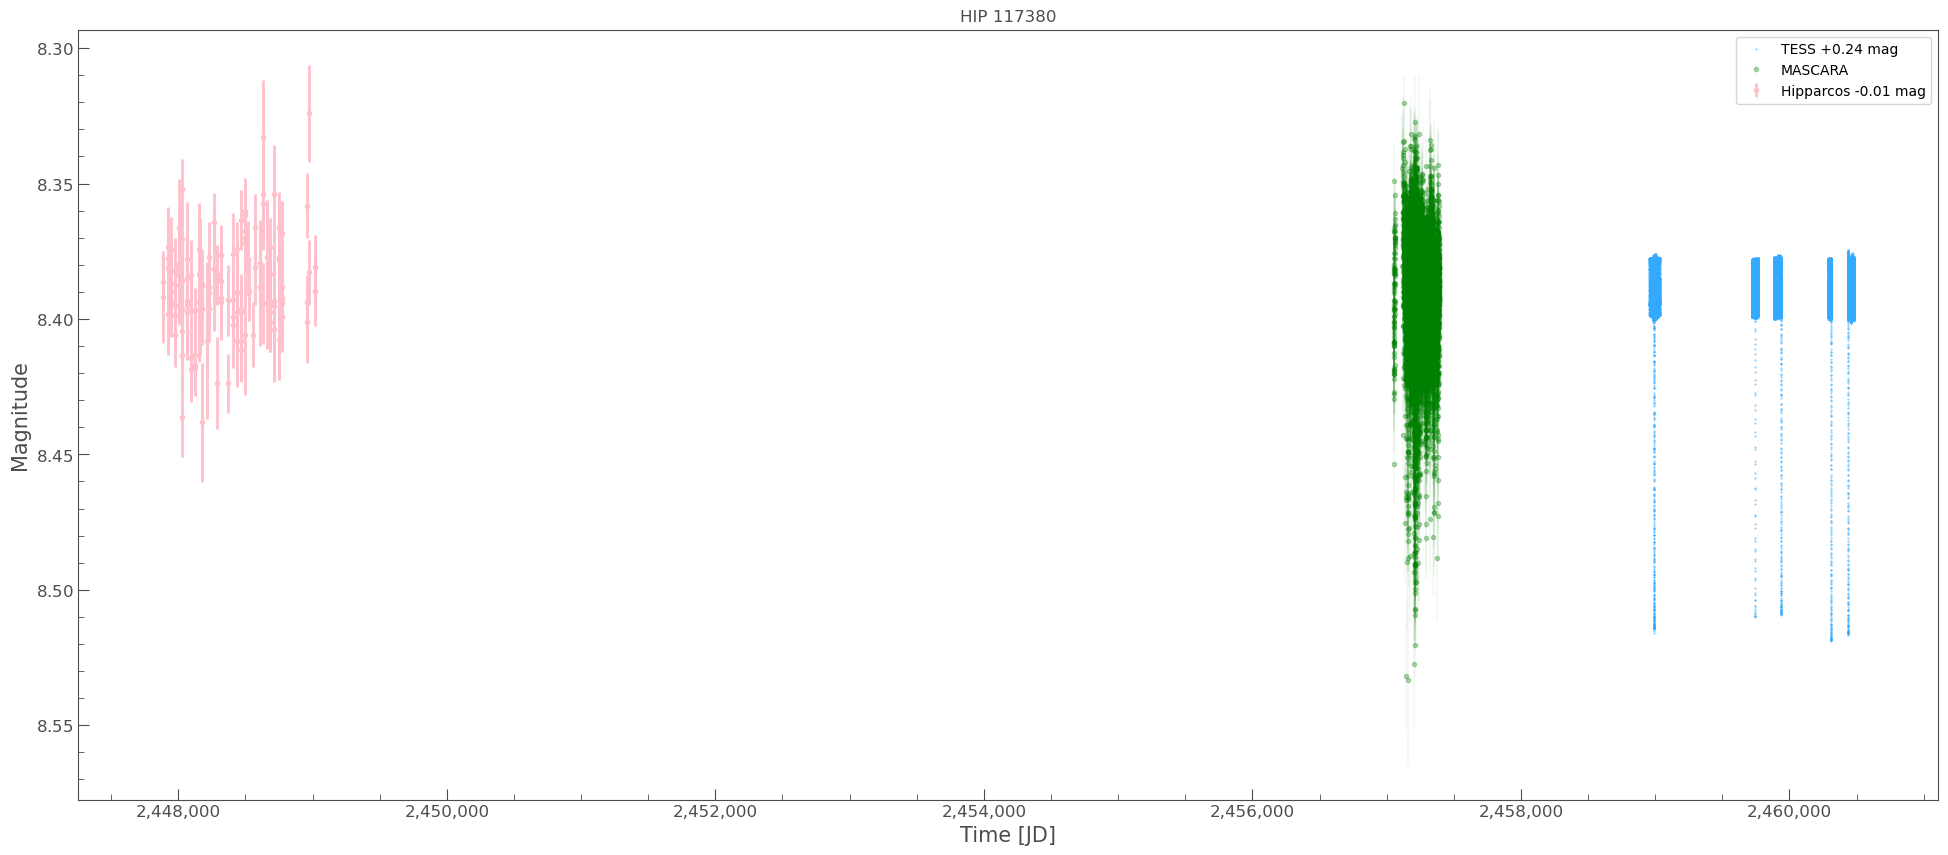

In [215]:
# reload(lkem)
# Not needed
plot_options = lkem.get_default_plot_multi_bands_options_copy()
plot_options[0][1]["zorder"] = 8  # push TESS data to the near the top
plot_options[1][1]['linewidth'] = 0.2
plot_options[1][1]['alpha'] = 0.3
plot_options[2][1]['linewidth'] = 2
plot_options[2][1]['zorder'] = 9 # push HIP data to the top

ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(24, 10), target_name=primary_name, plot_options=plot_options);
ax.set_title(ax.get_title() + "");
ylim = (None, None)
ax.set_ylim(*ylim);

### Phase Plot - ELL


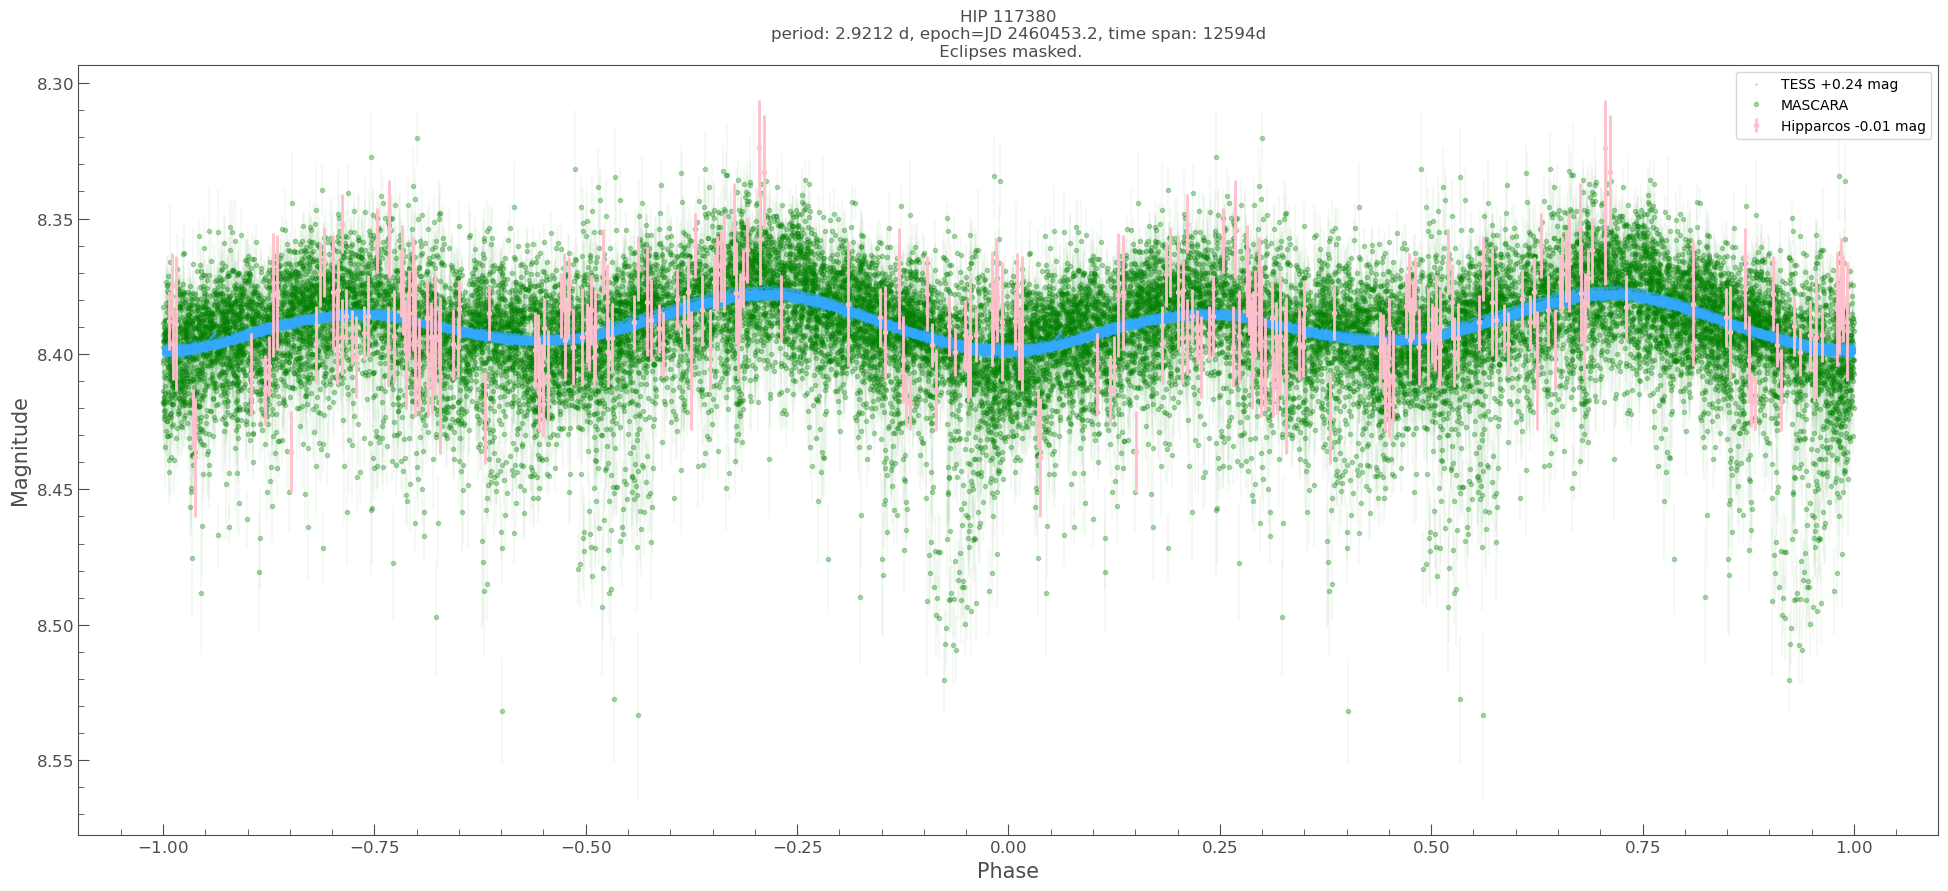

In [216]:
# reload(lkem)

# plot_options: in JD plot

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict_no_ecl,
    period=rot_period_final,
    epoch=Time(rot_epoch_time_hjd_final , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);
ax.set_ylim(*ylim);
ax.set_title(ax.get_title() + "\n Eclipses masked.");


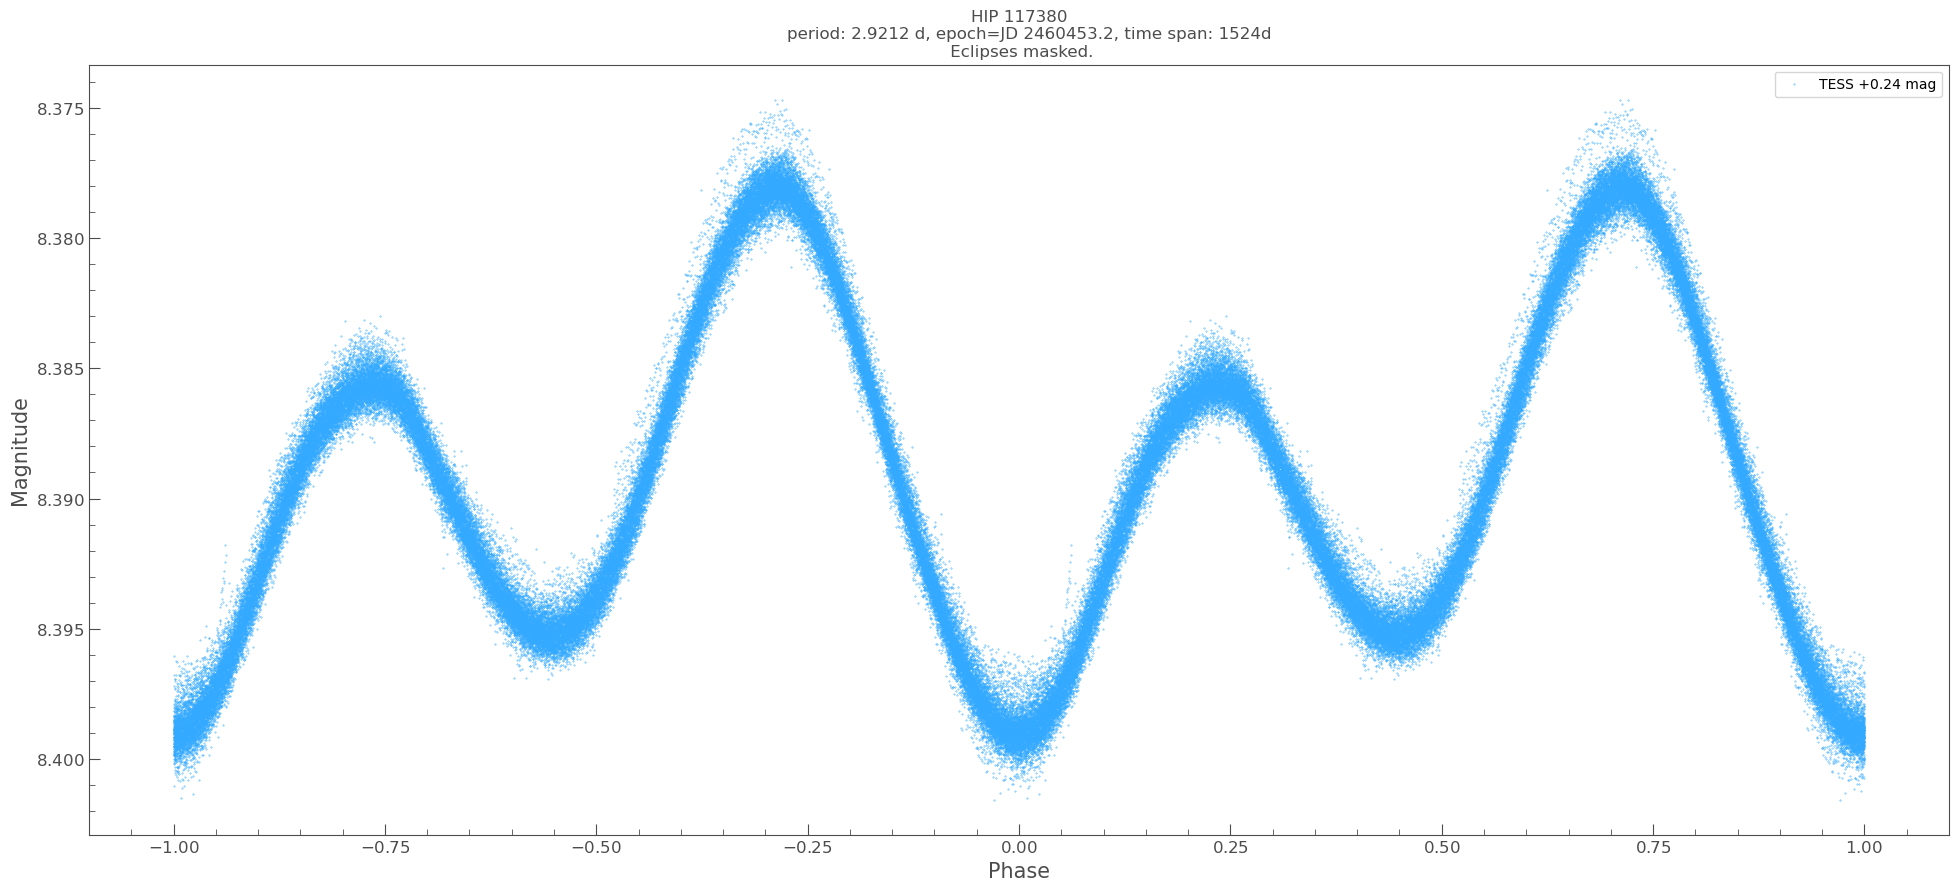

In [210]:
# TESS only plot
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    {"TESS": lc_combined_dict_no_ecl["TESS"]},
    period=rot_period_final,
    epoch=Time(rot_epoch_time_hjd_final , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);
ax.set_ylim(*ylim);
ax.set_title(ax.get_title() + "\n Eclipses masked.");

# Get the ELL amp in TESS
# _rot_min, _rot_max = 8.399, 8.377
# ax.axhline(_rot_min, c="red", linestyle="--", label="Min");
# ax.axhline(_rot_max, c="red", linestyle="--", label="Max");
# print("rot amp:", round(_rot_min - _rot_max, 3))

### Phase Plot - EA


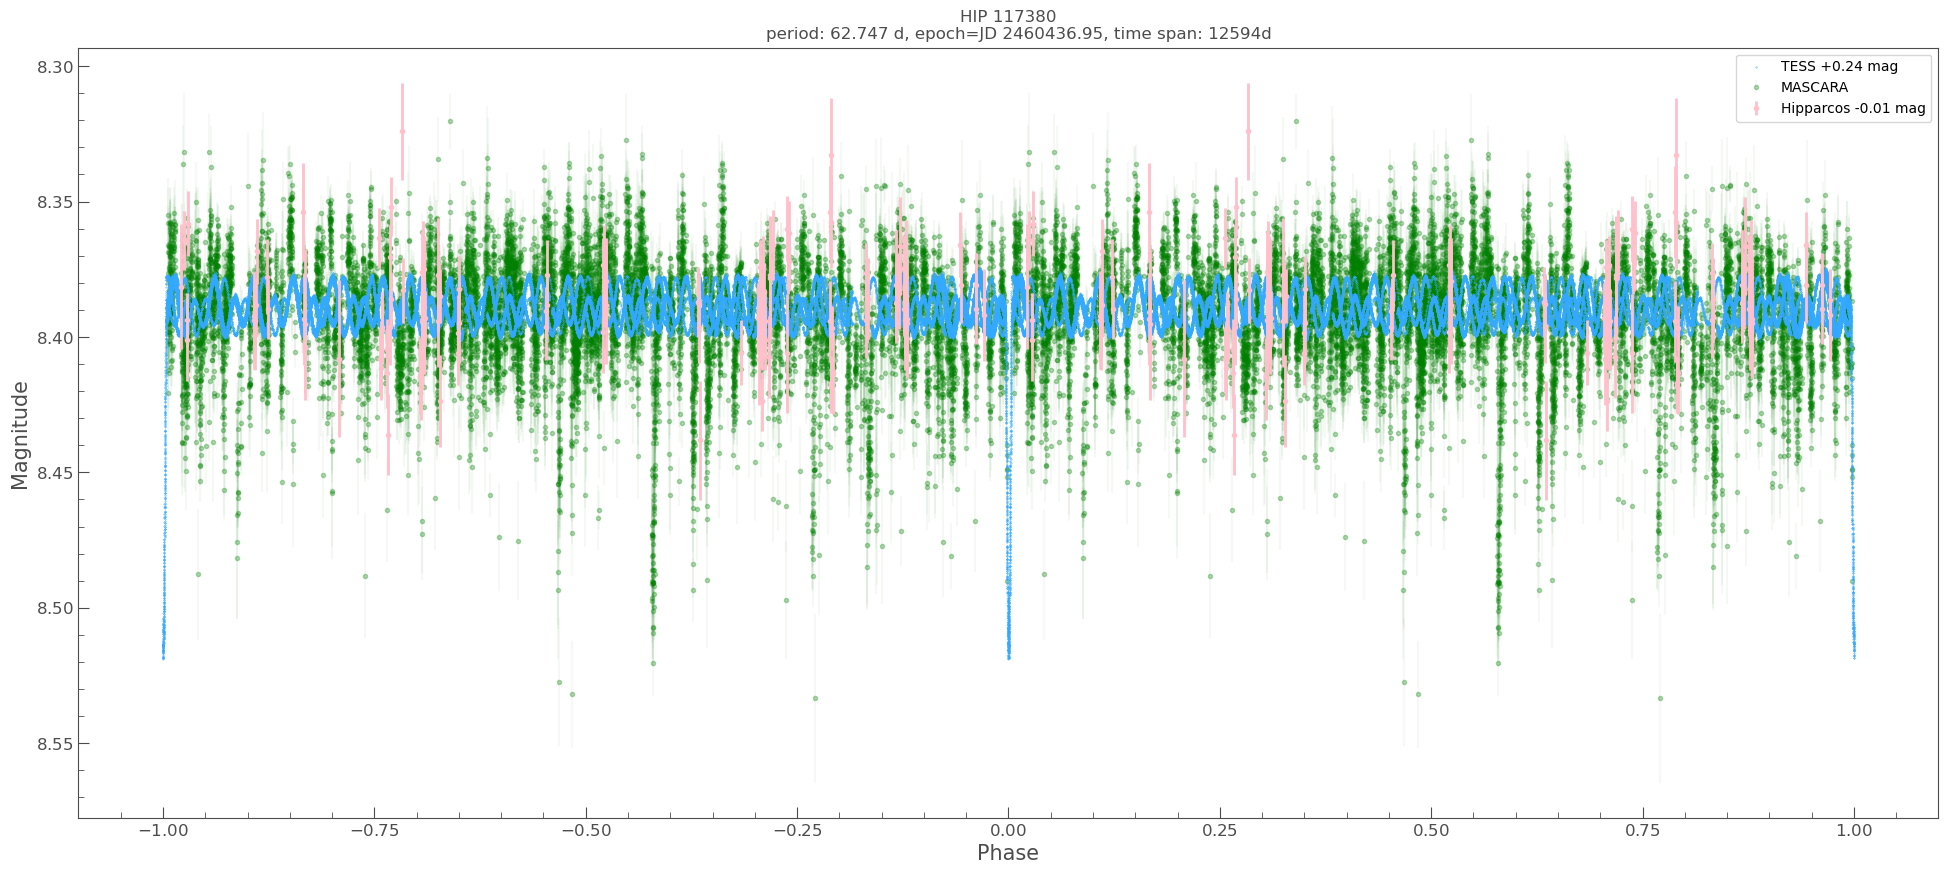

In [217]:
# reload(lkem)

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final,
    epoch=Time(epoch_time_hjd_final , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);
ax.set_ylim(*ylim);
ax.set_title(ax.get_title() + "");


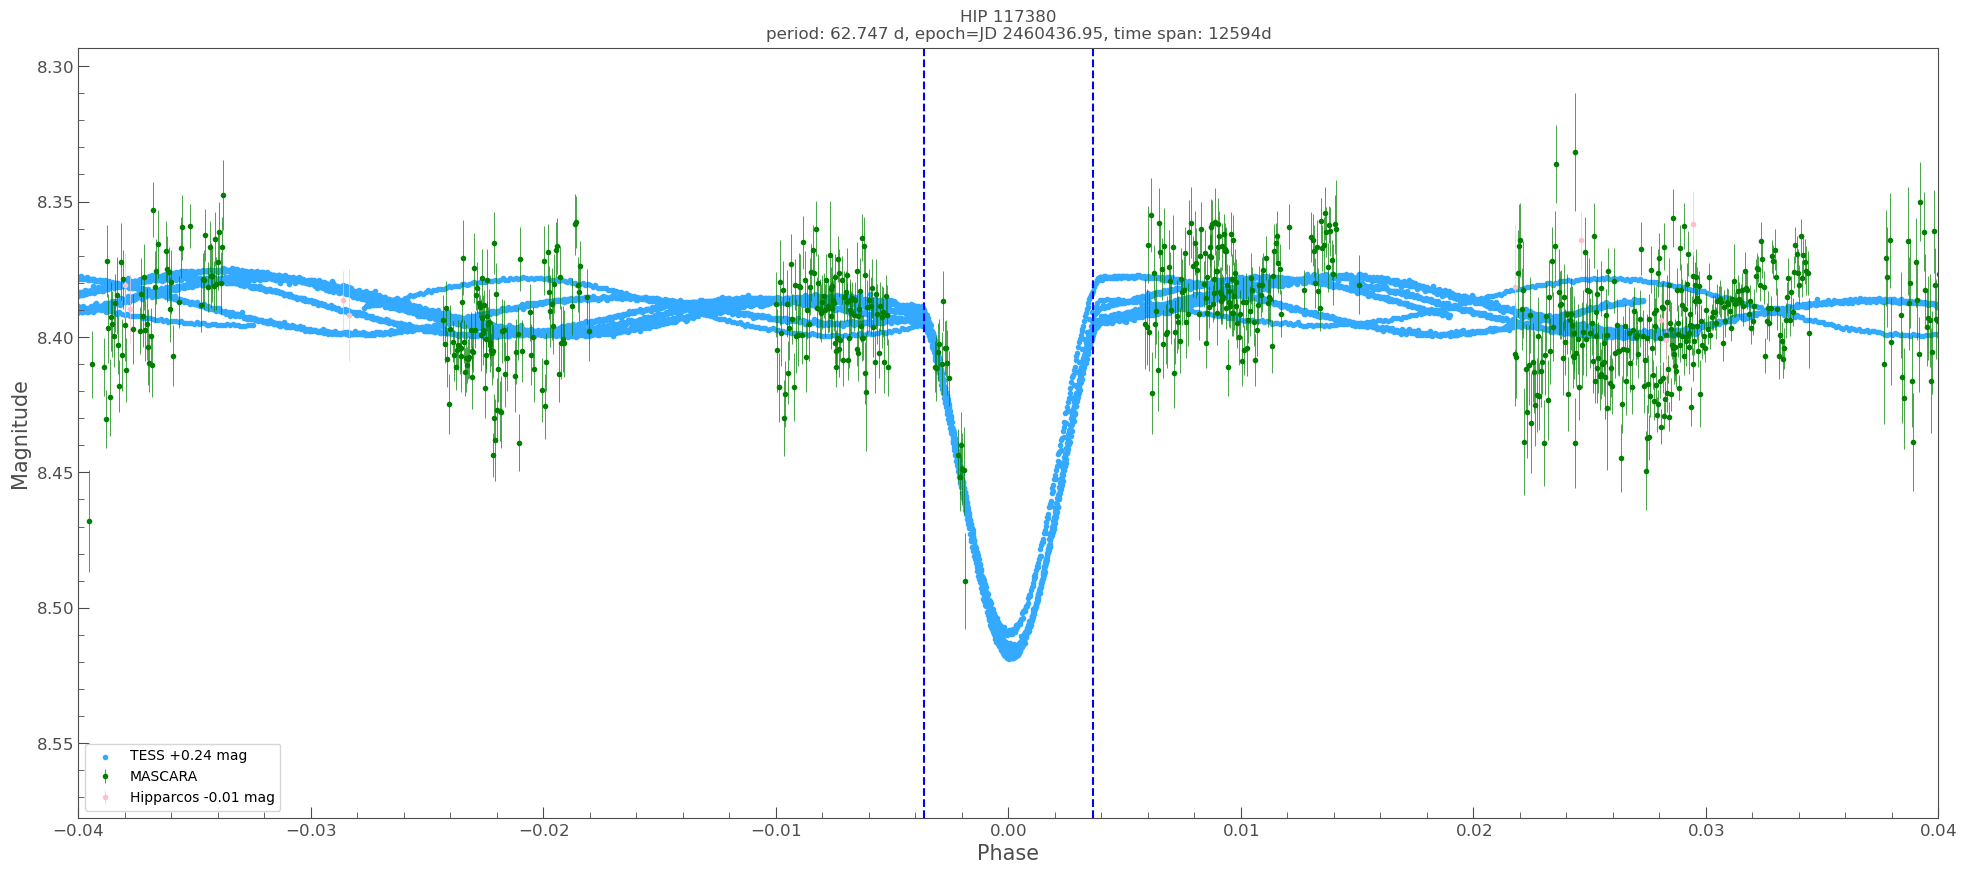

In [218]:

# zoom plot Min I
# - make TESS more visible:  larger dots
plot_options_zoom = lkem.get_default_plot_multi_bands_options_copy()
plot_options_zoom[0][1]["s"] = 9  # larger dots

# # to workaround astropy TypeError: cannot write to unmasked output when doing matplotlib errorbar  plot
# _lc = lc_combined_dict['TESS'].copy()
# _lc.flux_err = _lc.flux_err.filled(np.nan)

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final,
    epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_i_final  ,  # for plotting only
    figsize=(24, 10),
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,  #
);
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
# ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.04, 0.04);  # to see primary in details



## VSX Report Table

In [151]:
def report_to_df(report):
    df = pd.DataFrame()
    df["Field"] = report.keys()
    df["Value"] = report.values()
    return df


def vsx_phase(phase):
    # the phase I used above is from [-0.5, +0.5]
    # convert to the phase [0, 1[ used by VSX
    if phase < -0.5 or phase > 0.5:
        raise ValueError(f"Input phase needs to be in [-0.5, 0.5] range. Actual: {phase}")
    if phase >= 0:
        return phase 
    else: 
        return 1 + phase


In [158]:
# test the num of digits needed for eclipse duration percent

print(duration_hr_min_i_final / 24 / period_final * 100)
print(duration_hr_min_i_final, period_final * 0.7 / 100 * 24)  # too short
print(duration_hr_min_i_final, period_final * 0.73 / 100 * 24)  # 2 digits needed

0.7304466083371848
11.0 10.541495999999999
11.0 10.9932744


In [235]:
import bibs_utils
# reload(bibs_utils)


# TIC are not added, given the entry refers to thw whole system per SO
other_names = f"TIC {tic},2MASS J23475962+8033537,Gaia DR3 2283290655636466304"  # TIC is not used as the primary name so it's here. Others: ExoFOP and  SIMBAD
other_names += ",HD 223343,BD+79 793,GSC 04610-00256,SAO 3971"  # Useful IDs from SIMBAD, Not in GCPD

remarks = (
    f"""Eclipse Min I amplitude: {amp_min_i_flux_mag} TESS. ELL elements: {rot_epoch_time_hjd_final:.2f} + {rot_period_final} x E , amplitude 0.027 (MASCARA, clear)"""  # 0.027 amp is from exsiting VSX entry / MASCARA paper
)

revision_comment = (
    "Type, ELL period / epoch, eclipsing  period / epoch from TESS, MASCARA and Hipparcos data. "
    "Total and eclipsing amplitudes from TESS data. ELL amplitude from MASCARA data. Position from Gaia DR3."
)


BIBS = bibs_utils.BIBS
vsx_report = dict(
    Position=f"{target_coord.ra.value}, {target_coord.dec.value}",
    # Primary_Name=primary_name,  # no change
    Other_Names=other_names,
    Variable_Type="EA+ELL",  
    # Spectral Type: no change (still AO)
    # Spectral_Type="",  
    # Spectral_Type_Uncertain=False,
    # No update the reference mag (MASCARA / ASCC 2.5)
    # Maximum_Magnitude=f"",  
    # Maximum_Magnitude_band="",
    Minimum_Magnitude=f"{amp_total_flux_mag}",   
    Minimum_Magnitude_band="TESS",  
    Minimum_Is_Amplitude=True,
    Period=f"{period_final}",  
    Epoch=f"{epoch_time_hjd_final:}",   # no change
    Rise_Duration_Pct=f"{duration_hr_min_i_final / 24 / period_final * 100:.2f}",
    # Discoverer="", 
    Remarks=remarks,
    Revision_Comment=revision_comment,
    Reference0_Name=BIBS.TESS_N,
    Reference0_Bib=BIBS.TESS_B,
    Reference1_Name=BIBS.TESS_SPOC_N,
    Reference1_Bib=BIBS.TESS_SPOC_B,
    Reference2_Name=BIBS.HIP_N,
    Reference2_Bib=BIBS.HIP_B,
    # MASCARA arlready in reference
)


def print_long_fields(report):
    other_names_list = report["Other_Names"].split(",")
    print("Other Names (1 line each):")
    print("\n".join(other_names_list))
    print("")
    print(report["Remarks"])
    print("")
    print(report["Revision_Comment"])

print_long_fields(vsx_report)
with pd.option_context('display.max_colwidth', None):
    display(report_to_df(vsx_report))


# Combined LC probably not needed for EA with no long term variation
# tic385464250_combined_plot.png : Combined light curve - Combined light curve from from TESS (QLP) and ASAS3, shifted to ASAS3.
print("""
tic388508344_phase_plot_eclipses.png : EA Phase Plot - EA Phase Plot from TESS, MASCARA, and Hipparcos data. Shifted to MASCARA with reference mag added.
tic388508344_phase_plot_eclipses_zoom_min_i.png : EA Phase Plot (Min I Zoom) - EA Phase Plot from EA Phase Plot from TESS, MASCARA, and Hipparcos data. Zoomed around Min I.
tic388508344_phase_plot_ell.png : ELL Phase Plot - ELL Phase Plot from TESS, MASCARA, and Hipparcos data. Shifted to MASCARA with reference mag added. Eclipses masked.
tic388508344_phase_plot_ell_tess.png : ELL Phase Plot (TESS only) - ELL Phase Plot from TESS data only. Eclipses masked.
""")


Other Names (1 line each):
TIC 388508344
2MASS J23475962+8033537
Gaia DR3 2283290655636466304
HD 223343
BD+79 793
GSC 04610-00256
SAO 3971

Eclipse Min I amplitude: 0.12 TESS. ELL elements: 2460453.20 + 2.9212 x E , amplitude 0.027 (MASCARA, clear)

Type, ELL period / epoch, eclipsing  period / epoch from TESS, MASCARA and Hipparcos data. Total and eclipsing amplitudes from TESS data. ELL amplitude from MASCARA data. Position from Gaia DR3.


Field  \
0                 Position   
1              Other_Names   
2            Variable_Type   
3        Minimum_Magnitude   
4   Minimum_Magnitude_band   
5     Minimum_Is_Amplitude   
6                   Period   
7                    Epoch   
8        Rise_Duration_Pct   
9                  Remarks   
10        Revision_Comment   
11         Reference0_Name   
12          Reference0_Bib   
13         Reference1_Name   
14          Reference1_Bib   
15         Reference2_Name   
16          Reference2_Bib   

                                                                                                                                                                                                 Value  
0                                                                                                                                                                      356.99837801425, 80.56494509976  
1                                                                                      TIC 388508344,2MASS J23475962+8033537,Gaia DR3 2283290655636466304,HD 223343,BD+79 793,GSC 04610-00256,SAO 3971  
2                                                                                                                                                                                               EA+ELL  
3                                                                                                                                                                                                 0.14  
4                                                                                                                                                                                                 TESS  
5                                                                                                                                                                                                 True  
6                                                                                                                                                                                               62.747  
7                                                                                                                                                                                           2460436.95  
8                                                                                                                                                                                                 0.73  
9                                                                                         Eclipse Min I amplitude: 0.12 TESS. ELL elements: 2460453.20 + 2.9212 x E , amplitude 0.027 (MASCARA, clear)  
10  Type, ELL period / epoch, eclipsing  period / epoch from TESS, MASCARA and Hipparcos data. Total and eclipsing amplitudes from TESS data. ELL amplitude from MASCARA data. Position from Gaia DR3.  
11                                                                                                                           Ricker, G. R.; et al., 2014, Transiting Exoplanet Survey Satellite (TESS)  
12                                                                                                                                                                                 2014SPIE.9143E..20R  
13                                                                                                   Caldwell, D. A.; et al., 2020, TESS Science Processing Operations Center FFI Target List Products  
14                                                                                                                                                                                 2020RNAAS...4..201C  
15                                                                                                                                Perryman, M. A. C.; et al., 1997, The HIPPARCOS and TYCHO catalogues  
16                                                             


tic388508344_phase_plot_eclipses.png : EA Phase Plot - EA Phase Plot from TESS, MASCARA, and Hipparcos data. Shifted to MASCARA with reference mag added.
tic388508344_phase_plot_eclipses_zoom_min_i.png : EA Phase Plot (Min I Zoom) - EA Phase Plot from EA Phase Plot from TESS, MASCARA, and Hipparcos data. Zoomed around Min I.
tic388508344_phase_plot_ell.png : ELL Phase Plot - ELL Phase Plot from TESS, MASCARA, and Hipparcos data. Shifted to MASCARA with reference mag added. Eclipses masked.
tic388508344_phase_plot_ell_tess.png : ELL Phase Plot (TESS only) - ELL Phase Plot from TESS data only. Eclipses masked.

